# The retail unit price prediction for the Imaginary Auto Company

### Table of Contents

## 1. Summary for the Imaginary Auto Company project

## 2. Import data and packages

## 3. Derivative features based on the proposed hypotheses

## 4. Missing values and outliers

## 5. Exploratory Data Analysis(EDA)

## 6. Machine learning models

## 7. Hyperparameters tuning

## 8. Conclusions

## 1. Summary for the Imaginary Auto Company project

### 1.1 Main goal

Imaginary Auto Company in the year 2160  requested you to build a model to recommend unit price($000) for cars for retail segment based on only retail data. Your colleagues from pricing, sales and strategy have shared the past contracts data which includes both wholesalers and retailers with you.

### 1.2 Hypotheses proposals from colleagues
1) Cars of different types (as shown by item_class_l2 or item_class_l3- they are not sure which one) could have different pricing structures. Though cars that have few units sold are priced in a similar manner.

2) Pricing differs depending on size of customer (i.e size of their past purchases in terms of volume or total spend- they are not sure which one).

3) While pricing a car, recent transactions have higher influence on price than old transactions.

4) The price that a customer last paid for a car is an important factor in pricing.

### 1.3 Another important consideration
While building your model, the total revenue from your model should be higher or at least not much lower than the actual revenue.

### 1.4 Results:
1) Accuracy of model (as measured by R2, RMSE).

2) To show them visually how the predicted prices compare to the actual prices, draw a chart showing the % difference between the them.

3) The total revenue generated by your model vs the actual revenue.

### 1.5 Notes
The imaginary auto universe of 2160 is very different from the current auto industry hence any knowledge you have about the current auto industry (say around prices of different cars, no. of units sold, locations of suppliers or customers etc) will not be relevant in 2160.

The documentation for the project is located at:

"C:\Users\Administrator\Documents\Python_Scripts\Interview_Projects\Sr_DS_Cargill\Imaginary Auto Company Competition.docx"

The dataset is located at: 

"C:\Users\Administrator\Documents\Python_Scripts\Interview_Projects\Sr_DS_Cargill\Imaginary Auto Company.xlsx"

## 2. Import data and packages

### 2.1 Install and import packages

In [194]:
# Install relevent packages
# !pip install pandas_profiling
# !pip install pyqt5
# !pip install optuna

In [195]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [11, 7]

import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')

# Import preprocessing packages
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Import ML models
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# Import train_test_split
from sklearn.model_selection import train_test_split
# Import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
# Import MSE and CV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

# Hyperpapameters tunning libraries
from sklearn.feature_selection import RFE, RFECV
import optuna

%matplotlib inline

### 2.2 Import data

In [196]:
# import the raw data
all_cars = pd.read_excel(r'C:\Users\Administrator\Documents\Python_Scripts\Interview_Projects\Sr_DS_Cargill\Imaginary Auto Company.xlsx',sheet_name = 'Contracts data') 

In [197]:
# View the information of the raw data
all_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80493 entries, 0 to 80492
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                80493 non-null  int64         
 1   booking to delivery date  80493 non-null  object        
 2   unit price($000)          80493 non-null  float64       
 3   type of sale              80493 non-null  object        
 4   date of sale              80493 non-null  datetime64[ns]
 5   mode of transport         80493 non-null  object        
 6   no of units               80493 non-null  float64       
 7   cust_group_name           80493 non-null  object        
 8   cust_segment_name         80473 non-null  object        
 9   Customer Id               80493 non-null  object        
 10  delivery_month_from       80493 non-null  datetime64[ns]
 11  delivery_month_to         80493 non-null  datetime64[ns]
 12  type              

In [198]:
# Check the 'type of sale' feature
all_cars['type of sale'].unique()

array(['retail', 'wholesale'], dtype=object)

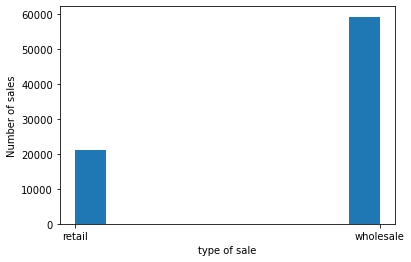

In [199]:
# Plot a histogram of "type of sale"
fig, ax = plt.subplots()
ax.hist(all_cars['type of sale'])
ax.set_xlabel("type of sale")
ax.set_ylabel("Number of sales")
plt.show()

Notes: It is interesting to compare the retail pricing model with the wholesale pricing model.

### 2.3 Select the retail data

In [200]:
# Select the retail data
car = all_cars[all_cars['type of sale']== 'retail']

In [201]:
# Rename the column names: replace space in the column names with '_'
car.columns = car.columns.str.replace(' ', '_')
# car.head();

In [202]:
# Drop the irrelevant index column 'Unnamed:_0' column
# Drop the specified label of 'type_of_sale' which is not a variable
car = car.drop(['Unnamed:_0','type_of_sale'], axis=1)

In [203]:
# Change the types
car = car.astype({'plant_nr': 'str', 'shipto_nr': 'str', 'soldto_nr': 'str'})
car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21141 entries, 0 to 80003
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   booking_to_delivery_date  21141 non-null  object        
 1   unit_price($000)          21141 non-null  float64       
 2   date_of_sale              21141 non-null  datetime64[ns]
 3   mode_of_transport         21141 non-null  object        
 4   no_of_units               21141 non-null  float64       
 5   cust_group_name           21141 non-null  object        
 6   cust_segment_name         21129 non-null  object        
 7   Customer_Id               21141 non-null  object        
 8   delivery_month_from       21141 non-null  datetime64[ns]
 9   delivery_month_to         21141 non-null  datetime64[ns]
 10  type                      21141 non-null  object        
 11  item_class_l1             21141 non-null  object        
 12  item_class_l2     

Notes: the columns of 'plant_city', 'plant_country_name' , 'cust_segment_name', 'most_expensive_part_l1', 'most_expensive_part_l2' contains less than 0.1% of missing values, 'shipto_city' contain less than 0.41% of missing values. 

### 2.4 Exploratory Data Analysis(EDA) for the raw data

In [204]:
# EDA by pandas_profiling
# pp.ProfileReport(car)

In [205]:
# The errors observations estimation

# % of negative observations of 'no_of_units'
n1  = car['no_of_units'][car['no_of_units']<0].count()/car['no_of_units'].count()*100
pr1 = "Negative observations of 'no_of_units' = {:.2f} %".format(n1)
print(pr1)
# % of sum of negative observations of 'no_of_units' in the sum of the positive obseravtions
n1sum = car['no_of_units'][car['no_of_units']<0].sum()/car['no_of_units'][car['no_of_units']>=0].sum()*100
pr1sum = "Sum of negative observations of 'no_of_units' = {:.2f} %".format(n1sum)
print(pr1sum)
# % of negative observations of 'unit_price($000)'
n1zero = car['no_of_units'][car['no_of_units']==0].count()/car['no_of_units'].count()*100
pr1zero = "Observations of ZERO values in 'no_of_units' = {:.2f} %".format(n1zero)
print(pr1zero)
# % of negative observations of 'unit_price($000)'
n2  = car['unit_price($000)'][car['unit_price($000)']<0].count()/car['unit_price($000)'].count()*100
pr2 = "Negative observations of 'unit_price($000)' = {:.2f} %".format(n2)
print(pr2)
# % of sum of negative observations of 'unit_price($000)' in the sum of the positive obseravtions
n2sum = car['unit_price($000)'][car['unit_price($000)']<0].sum()/car['unit_price($000)'][car['unit_price($000)']>=0].sum()*100
pr2sum = "Sum of negative observations of 'unit_price($000)' = {:.2f} %".format(n2sum)
print(pr2sum)
# % of negative observations of 'unit_price($000)'
n2zero = car['unit_price($000)'][car['unit_price($000)']==0].count()/car['unit_price($000)'].count()*100
pr2zero = "Observations of ZERO values in 'unit_price($000)' = {:.2f} %".format(n2zero)
print(pr2zero)

Negative observations of 'no_of_units' = 1.38 %
Sum of negative observations of 'no_of_units' = -0.01 %
Observations of ZERO values in 'no_of_units' = 12.80 %
Negative observations of 'unit_price($000)' = 1.65 %
Sum of negative observations of 'unit_price($000)' = -0.54 %
Observations of ZERO values in 'unit_price($000)' = 6.43 %


The sum of the negative observations of 'unit_price($000)' and 'no_of_units' are -0.54%, and -0.01 %, respectively. Therefore, these errors are negligible and we will drop it in the next subsection.

### 2.5 Data cleaning for the current features

In [206]:
# Clean data: Select the positive value observations of 'unit_price($000)' and 'no_of_units'
condition = (car['unit_price($000)']> 0) & (car['no_of_units']> 0)
car = car[condition]
# car.info()

## 3. Derivative features based on the proposed hypotheses

### 3.1 Cars of different types

Cars of different types (as shown by item_class_l2 or item_class_l3- they are not sure which one) could have different pricing structures. These features are included.

### 3.2 Size of their past purchases in terms of volume or total spend

Pricing differs depending on size of customer (i.e size of their past purchases in terms of volume or total spend- they are not sure which one).

Therefore, we derive the feature of the cumulative sum of each customer's past purchase size and totol spend.

In [207]:
# Sort the data by ['Customer_Id','date_of_sale'] for later use
car.sort_values(by= ['Customer_Id','date_of_sale'], ascending= True, inplace = True)

In [208]:
# define a new column to save the totol spend of each sale
car['totol_spend'] = car['unit_price($000)']* car['no_of_units']

Calculate the cumulative sum of a customer's recent past purchase size and totol spend.

Note: it is more convenient to process it in SQL which I would prefer for some data preprocessing.

In [209]:
# define a function to calculate the k terms cumulative sum of a customer's past purchases.
def cal_past_size(df,col,col_sum, k):
    test1 = pd.DataFrame([])
    for x in df['Customer_Id'].unique():
        test = df[df['Customer_Id'] == x ][col].cumsum() - df[df['Customer_Id'] == x ][col].shift(k).cumsum()
        test = test.to_frame().rename(columns={col: col_sum})
        test1 = pd.concat([test1, test])
    return test1

Study the size of the cumulative sum of a customer's recent past purchase size and totol spend.

The cumulative sum size is used to estimate the size of the customer, when it is too large the number of invalid observations increases, so the sum size should be limited.

We investigated the size and find it is reasonable in the range 4 - 7. We set it to be 5 below.

In [210]:
# Select the cumulative sum size
sum_size = 5
df_past_size = cal_past_size(car, 'no_of_units', 'past_size', sum_size)
df_past_spend = cal_past_size(car, 'totol_spend', 'past_spend', sum_size)
# Add these two columns to the dataframe of the data
car = pd.concat([car, df_past_size, df_past_spend],axis = 1)
# car.describe()

### 3.3 Recent transactions vs old transactions

While pricing a car, recent transactions have higher influence on price than old transactions.
We derive the period of the transactions from the earlist date.

In [211]:
car['transaction_period'] = (car.date_of_sale - car.date_of_sale.min()) / pd.to_timedelta(1, unit='D')
# car.info();

### 3.4 The price that a customer last paid for a car

The price that a customer last paid for a car is an important factor in pricing.
We derive the last paid unit price for each customer.

In [212]:
# Use the sorted data by ['Customer_Id','date_of_sale'] then shift one row to get the last paid price
# Note there is one(the first) row of each customer is not correct yet.
car['last_paid_price'] = car['unit_price($000)'].shift(1)
# reset the index
car.reset_index(drop=True, inplace=True)
# Fix the problem in the first row of each customer(set them as np.nan)
for x in car.index[1:]:
        if (car.loc[x, 'Customer_Id'] != car.loc[x - 1 ,'Customer_Id']):
            car.loc[x, 'last_paid_price'] = np.nan

### 3.5 Add addtional feature of the delivery period

Add addtional feature of the delivery period based on 'delivery_month_to' and 'delivery_month_from'.

In [213]:
# Add addtional feature of the delivery period and transform it into 'float64' type.
car['delivery_period'] = (car.delivery_month_to - car.delivery_month_from) / pd.to_timedelta(1, unit='D')

## 4. Missing values and outliers

### 4.1 Filling the missing values

The missing values observations are all less than 0.5% in the total number of observations.

These are negligible and we fill them properly.

In [214]:
# Filling the catergrical missing values with their modes
car['cust_segment_name'] = car['cust_segment_name'].fillna(car['cust_segment_name'].mode()[0]) 
car['plant_city'] = car['plant_city'].fillna(car['plant_city'].mode()[0]) 
car['plant_country_name'] = car['plant_country_name'].fillna(car['plant_country_name'].mode()[0]) 
car['most_expensive_part_l1'] = car['most_expensive_part_l1'].fillna(car['most_expensive_part_l1'].mode()[0]) 
car['most_expensive_part_l2'] = car['most_expensive_part_l2'].fillna(car['most_expensive_part_l2'].mode()[0]) 
car['shipto_city'] = car['shipto_city'].fillna(car['shipto_city'].mode()[0]) 
# Filling the missing values for the last paid price with zeros
car['last_paid_price'] = car['last_paid_price'].fillna(0)
car['past_size'] = car['past_size'].fillna(0) 
car['past_spend'] = car['past_spend'].fillna(0) 

### 4.2 Excluding the outliers

In [215]:
categorical_cols = car.select_dtypes(include=['object']).columns
numerical_cols = car.select_dtypes(include=['float64']).columns
datetime_cols = car.select_dtypes(include=['datetime64[ns]']).columns

In [216]:
# Check the skew of numerical features
car[numerical_cols].skew()

unit_price($000)      37.464393
no_of_units            6.489932
totol_spend            5.402567
past_size              2.976835
past_spend             5.714294
transaction_period    -0.417812
last_paid_price        2.972082
delivery_period        1.193607
dtype: float64

In [217]:
# Excluding the outliers using quantiles
no_out_cond = (car['unit_price($000)']<= car['unit_price($000)'].quantile(0.998)) &(car['no_of_units']<= car['no_of_units'].quantile(0.985)) & (car['totol_spend']<= car['totol_spend'].quantile(0.99)) & (car['past_spend']<= car['past_spend'].quantile(0.99)) & (car['last_paid_price']<= car['last_paid_price'].quantile(0.988))
car_no_out = car[no_out_cond]

In [218]:
# Drop the datetime64[ns] columns
car_no_out = car_no_out.drop(datetime_cols, axis=1)

In [219]:
# Check the skewnesses of numerical features after droping the outliers
# All the skewnesses are less than 3
car_no_out[numerical_cols].skew()

unit_price($000)      2.181523
no_of_units           2.306402
totol_spend           2.877967
past_size             2.716588
past_spend            2.714620
transaction_period   -0.405119
last_paid_price       2.079269
delivery_period       1.201860
dtype: float64

The data preprocessing is completed. The next section we will process the exploratory data analysis.

## 5. Exploratory Data Analysis(EDA)

### 5.1 EDA for categorical features

In [220]:
# Define the dataframes to select categorical or numerical features for EDA process
num_cols = list(numerical_cols)
cat_cols = list(categorical_cols)
cat_cols.append('unit_price($000)')
car_num = car_no_out[num_cols]
car_cat = car_no_out[cat_cols]

In [221]:
# Apply the EDA for categorical features
# pp.ProfileReport(car_cat)

High cardinality categorical features ['cust_group_name', 'Customer_Id', 'shipto_city' ,'shipto_nr', 'soldto_city', 'car_nr'] are identified.

We will make botplots and histogrms of them in the next step.

In [222]:
# Define a function to plot botplots and histogrms.
def cat_plt(df, col):
    plt.figure(figsize=(18,7))

    plt.subplot(1,2,1)
    plt.title(col + 'vs unit_price($000)')
    sns.countplot(car_cat[col], palette=("cubehelix"))

    plt.subplot(1,2,2)
    plt.title(col + ' vs unit_price($000)')
    sns.boxplot(x = df[col], y= df['unit_price($000)'], palette=("cubehelix"))
    plt.show()

In [223]:
# High cardinality categorical features
cat_neglect = ['cust_group_name', 'Customer_Id', 'shipto_city' ,'shipto_nr', 'soldto_city', 'car_nr']

# Low cardinality categorical features
cat_lefted = ['booking_to_delivery_date', 'mode_of_transport', 'cust_segment_name', 'type', 'item_class_l1', 
 'item_class_l2', 'item_class_l3', 'colour', 'plant_nr', 'plant_city', 'plant_country_name', 'most_expensive_part_l1',
 'most_expensive_part_l2', 'soldto_nr', 'shipto_country', 'soldto_country']

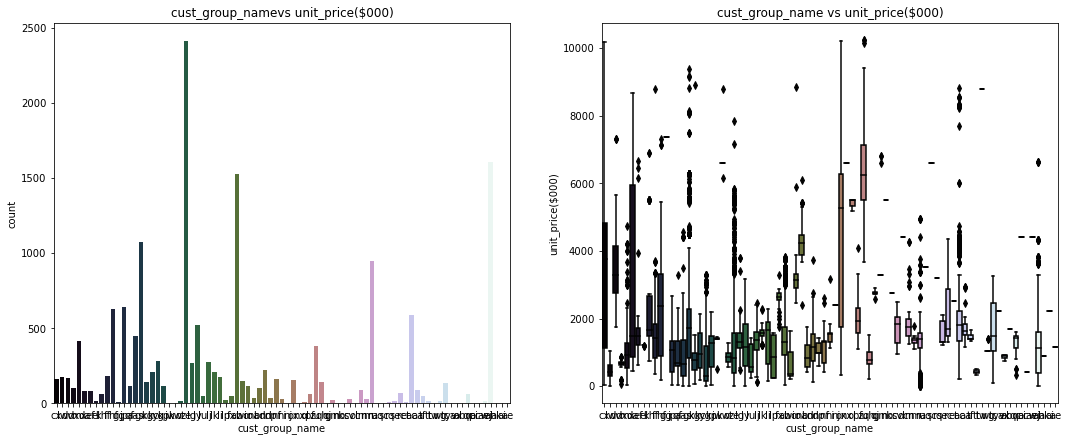

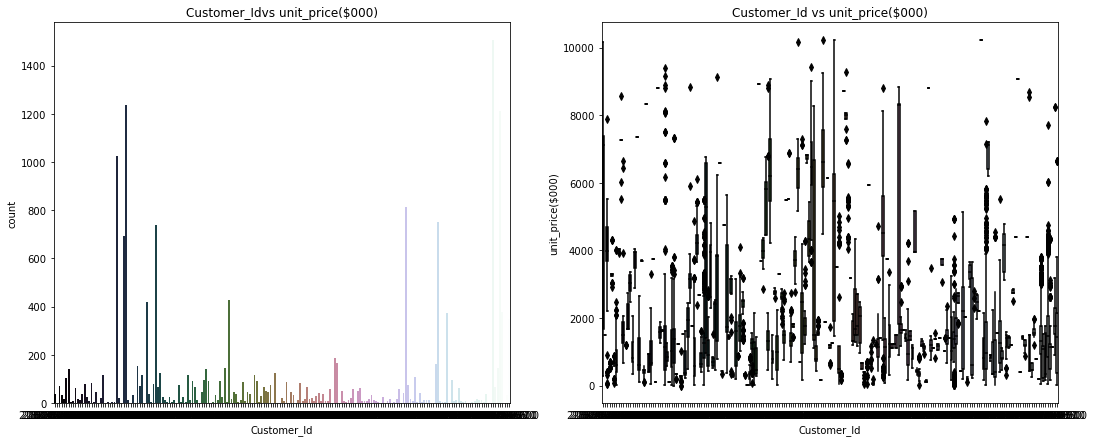

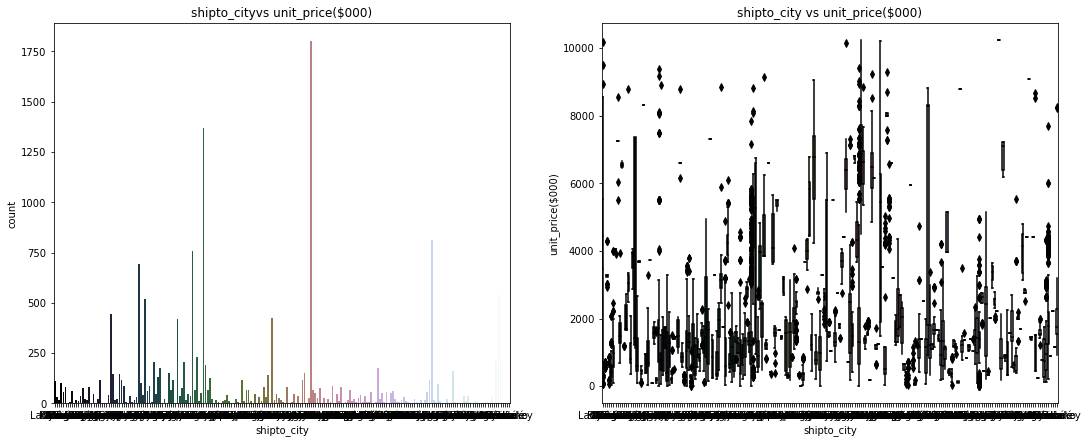

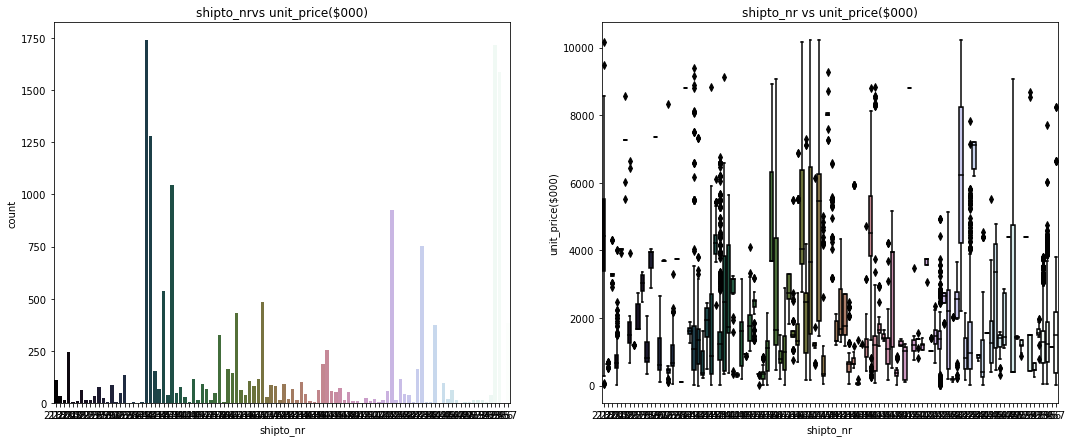

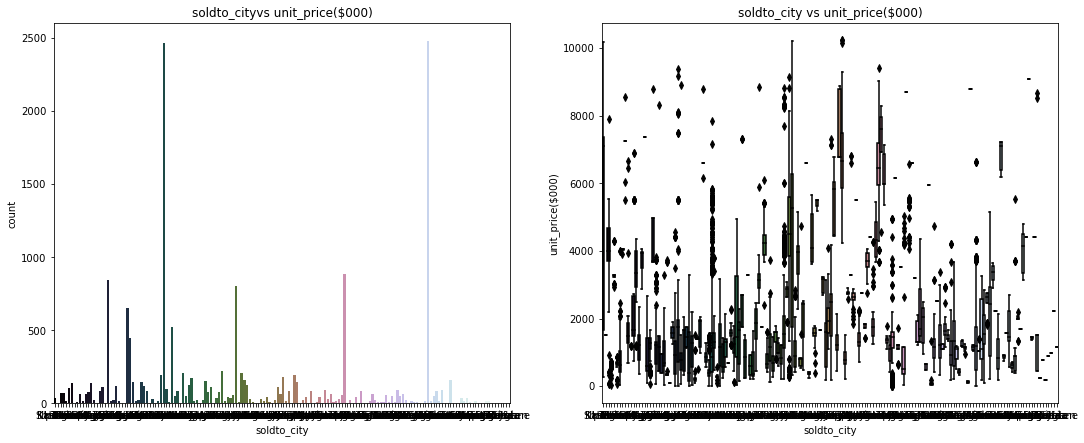

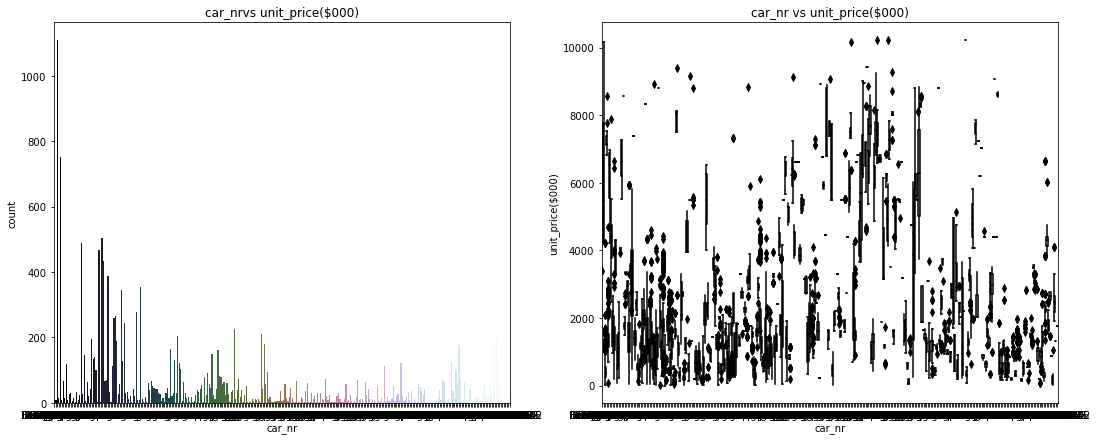

In [224]:
# Plot the categorical features with large number of categories (high cardinality)
for x in cat_neglect:
    cat_plt(car_cat,x)

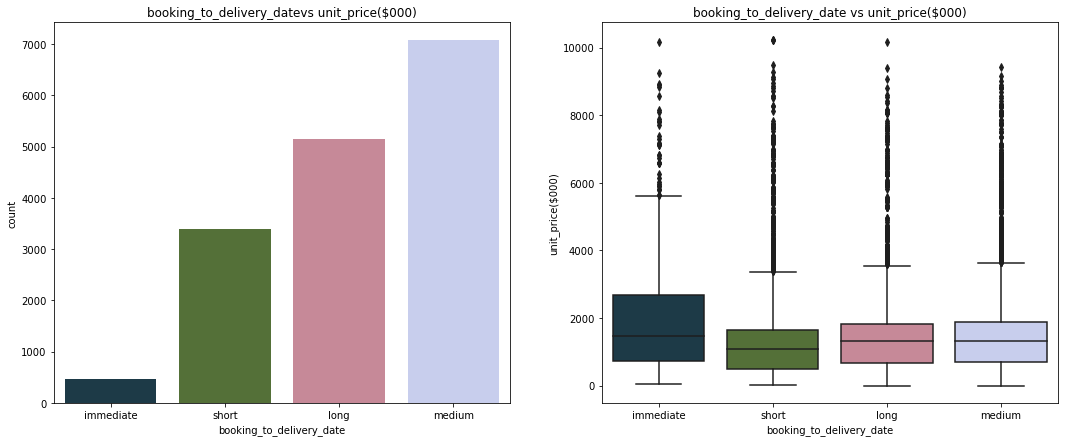

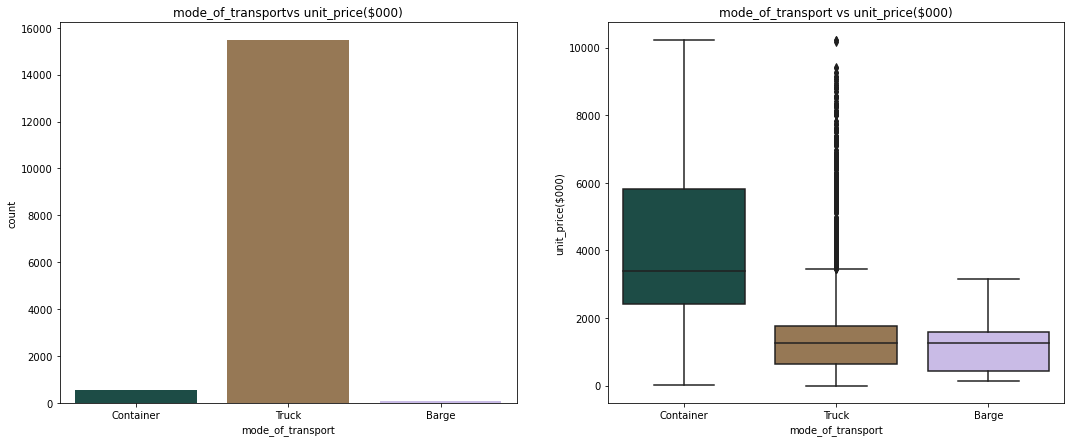

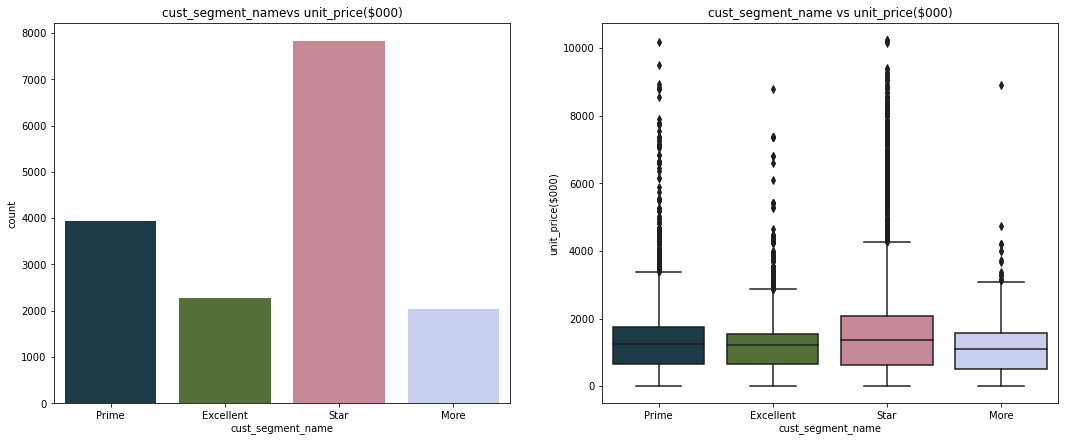

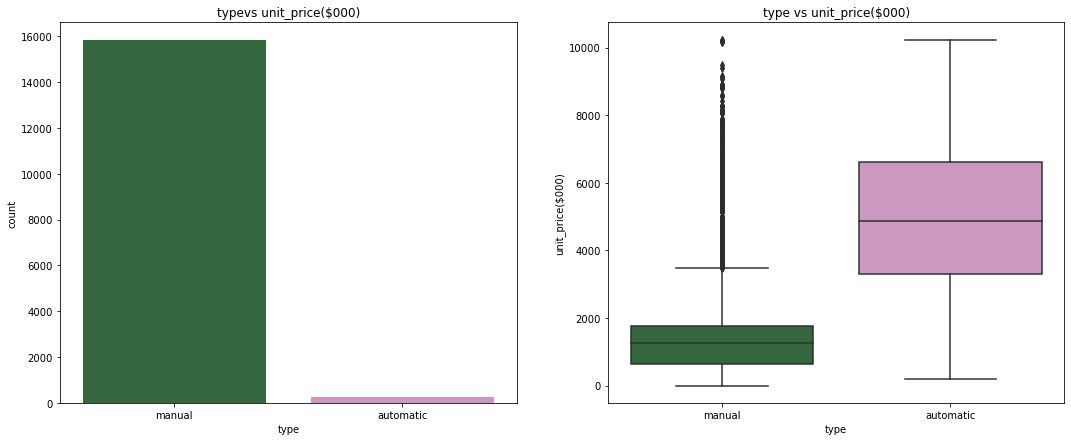

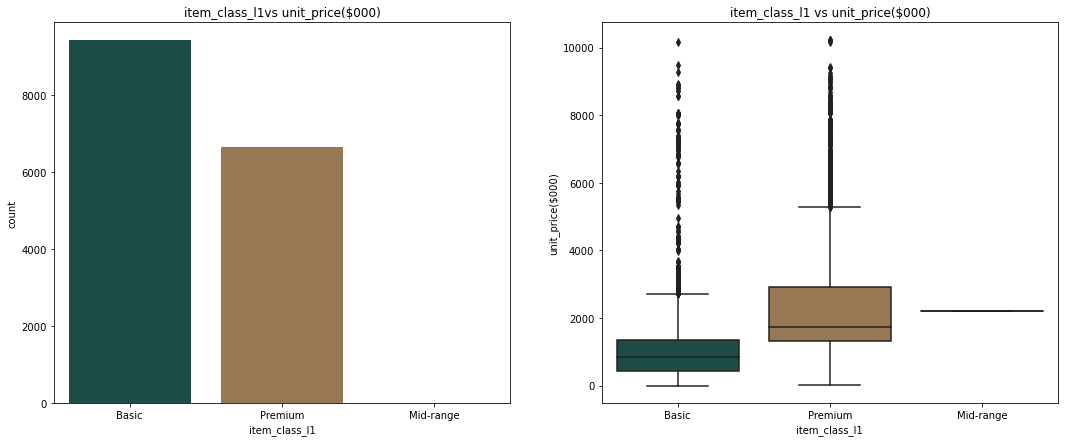

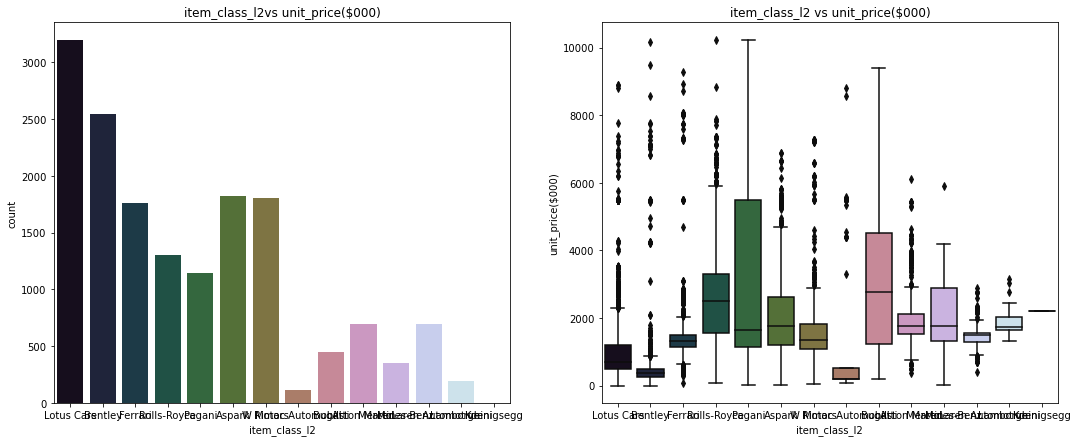

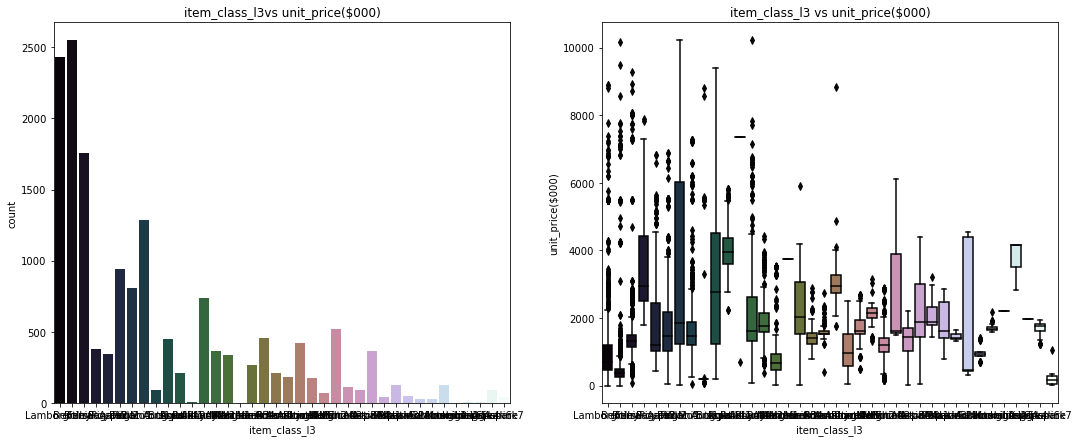

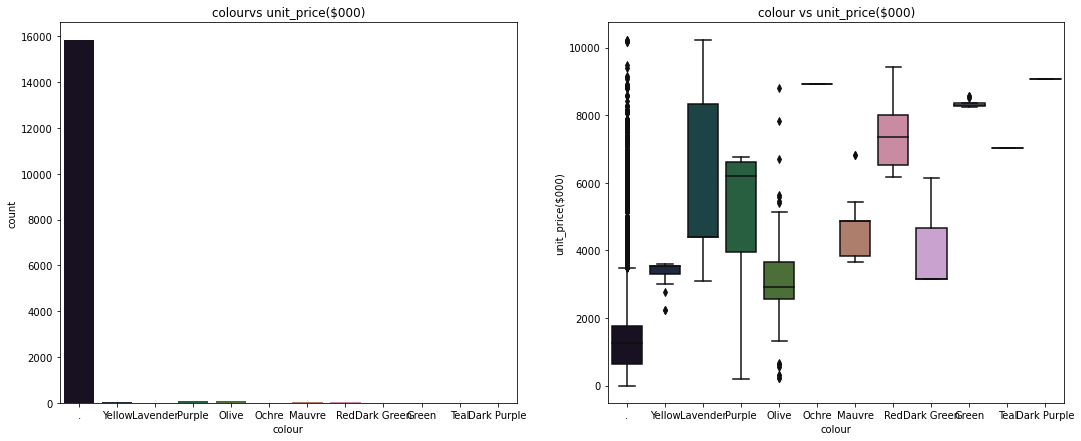

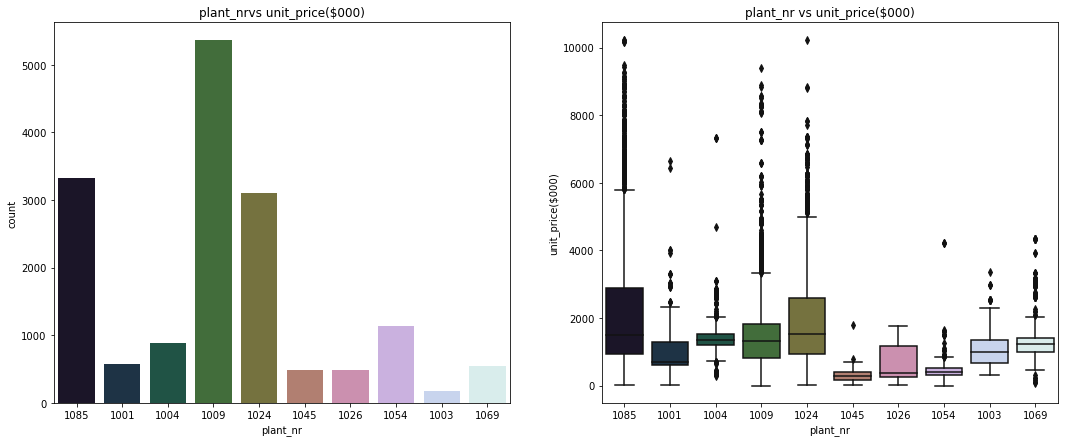

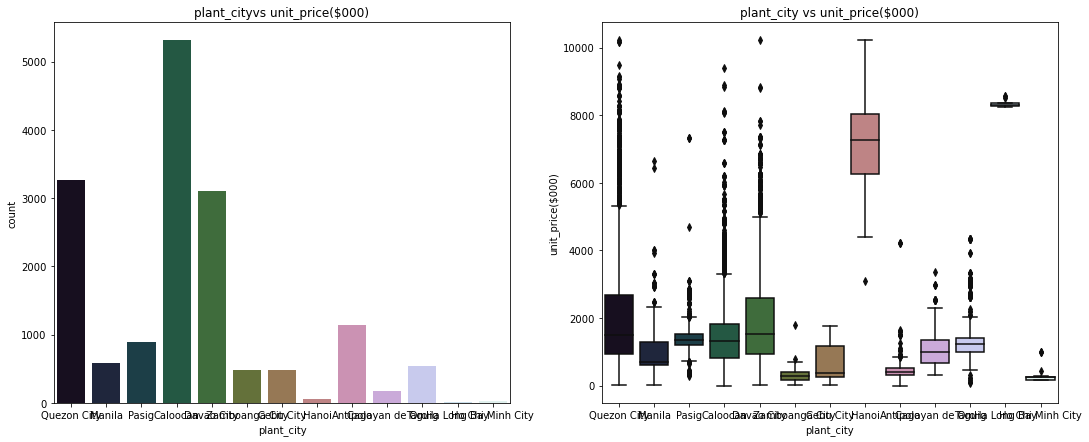

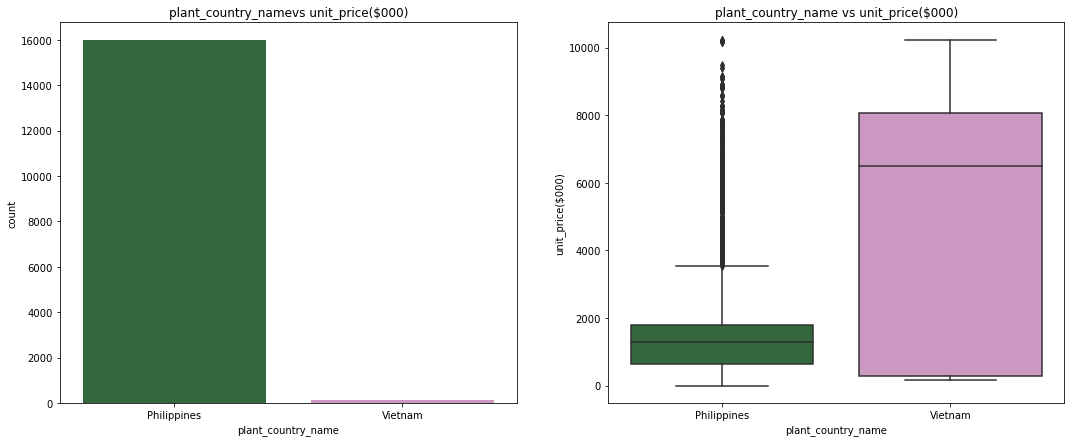

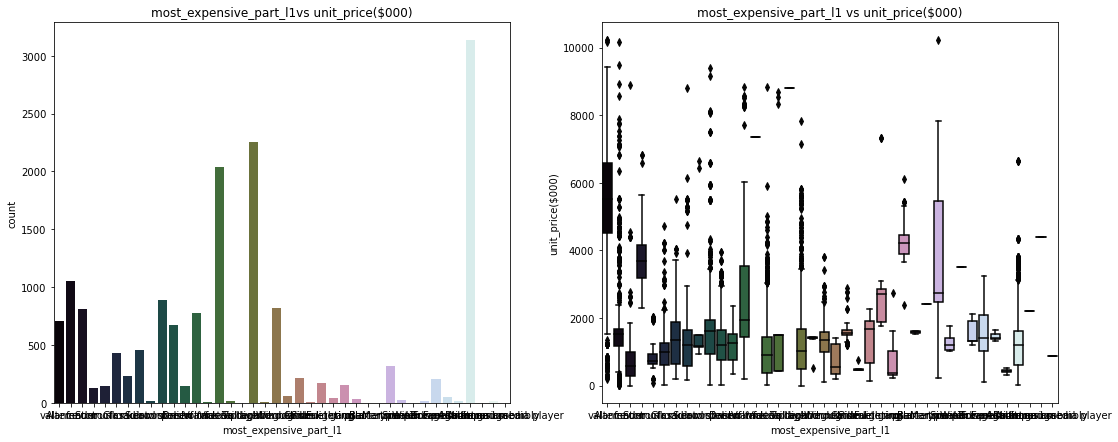

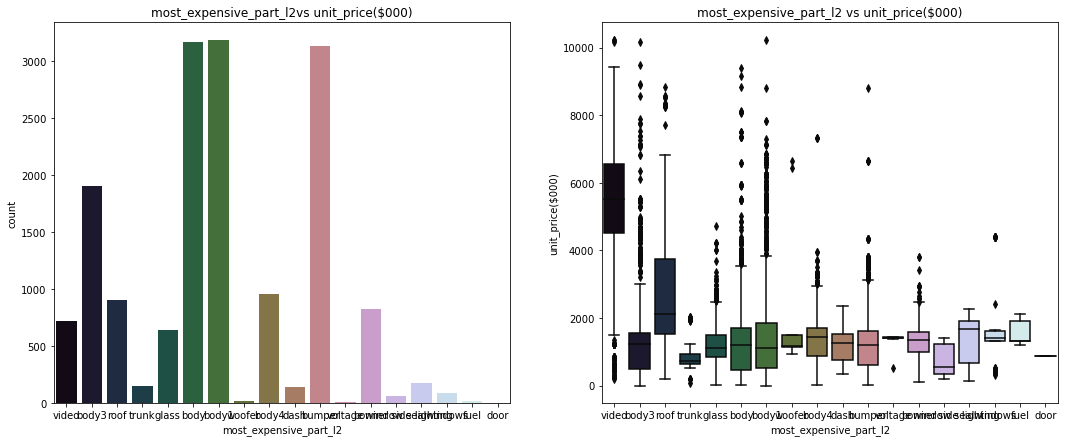

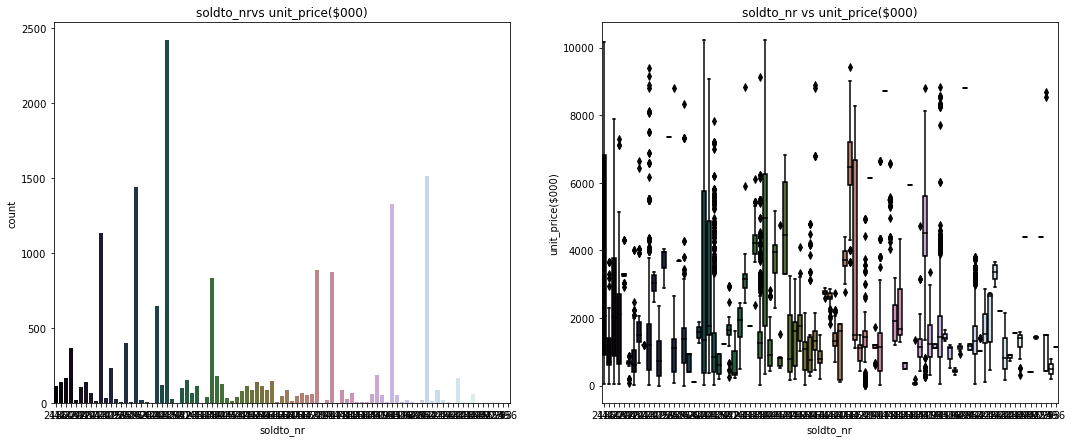

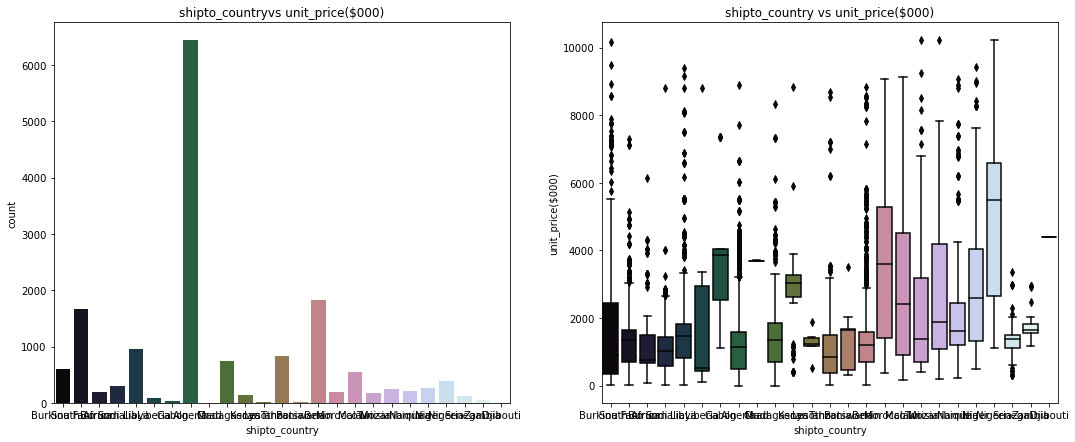

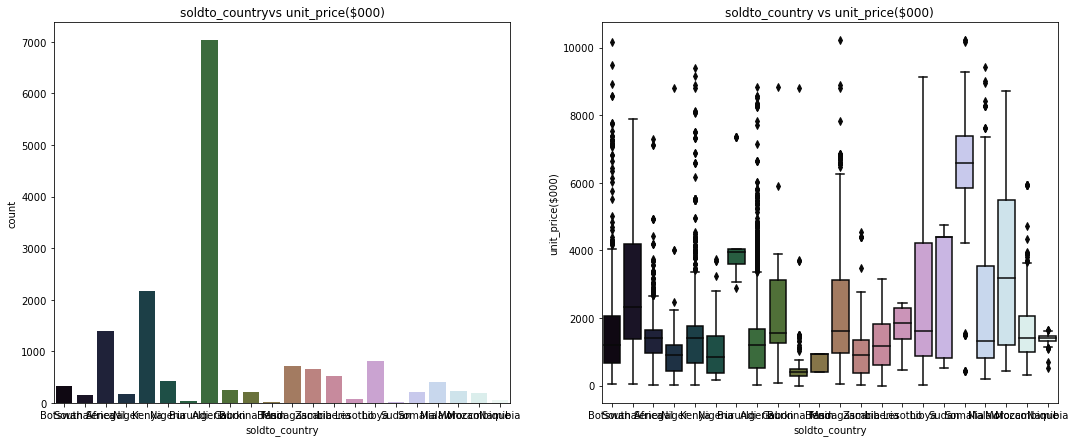

In [225]:
# Plot the categorical features with small number of categories(low cardinality)
for x in cat_lefted:
    cat_plt(car_cat,x)

From the valulization, the 'item_class_l1', 'item_class_l2', 'item_class_l3' show some impact in price difference in their different categories.

### 5.2 EDA for numerical features

In [226]:
# Apply the EDA for numerical features
# pp.ProfileReport(car_num)

### 5.3 EDA for all features

In [227]:
# Apply the EDA for all features
# pp.ProfileReport(car_no_out)

### 5.4 Crrelations analysis

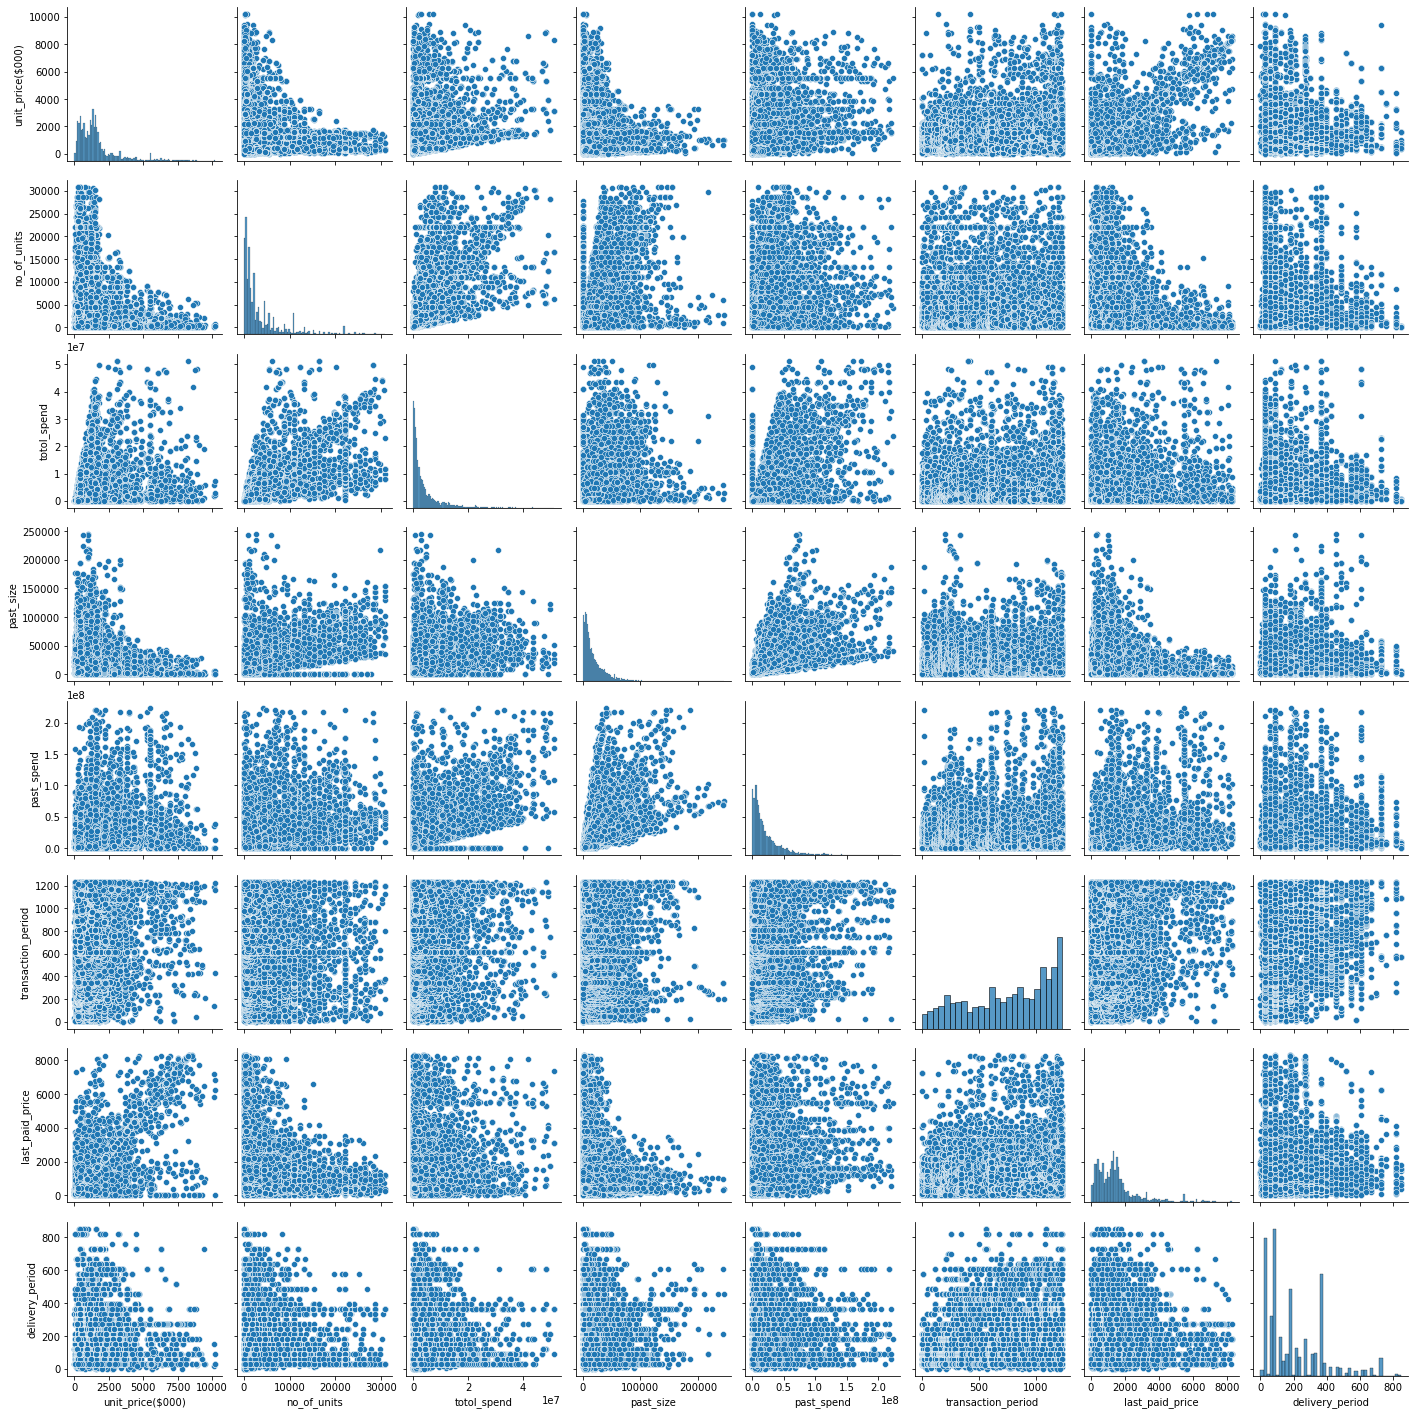

In [228]:
# Pair plot of numerical features to visualize the correlations
ax = sns.pairplot(car_no_out[num_cols])

In [229]:
# Correlations of the numerical features and the target price
car_no_out[num_cols].corr()

unit_price($000)  no_of_units  totol_spend  past_size  \
unit_price($000)            1.000000    -0.218193     0.254028  -0.186189   
no_of_units                -0.218193     1.000000     0.646713   0.578494   
totol_spend                 0.254028     0.646713     1.000000   0.365475   
past_size                  -0.186189     0.578494     0.365475   1.000000   
past_spend                  0.229209     0.390708     0.647784   0.637403   
transaction_period          0.134364    -0.086073     0.015552  -0.078410   
last_paid_price             0.797173    -0.178820     0.208619  -0.190959   
delivery_period             0.052836    -0.097731     0.000486  -0.052871   

                    past_spend  transaction_period  last_paid_price  \
unit_price($000)      0.229209            0.134364         0.797173   
no_of_units           0.390708           -0.086073        -0.178820   
totol_spend           0.647784            0.015552         0.208619   
past_size             0.637403           -0.078410        -0.190959   
past_spend            1.000000            0.051838         0.255831   
transaction_period    0.051838            1.000000         0.150590   
last_paid_price       0.255831            0.150590         1.000000   
delivery_period       0.025324            0.226934         0.070089   

                    delivery_period  
unit_price($000)           0.052836  
no_of_units               -0.097731  
totol_spend                0.000486  
past_size                 -0.052871  
past_spend                 0.025324  
transaction_period         0.226934  
last_paid_price            0.070089  
delivery_period            1.000000

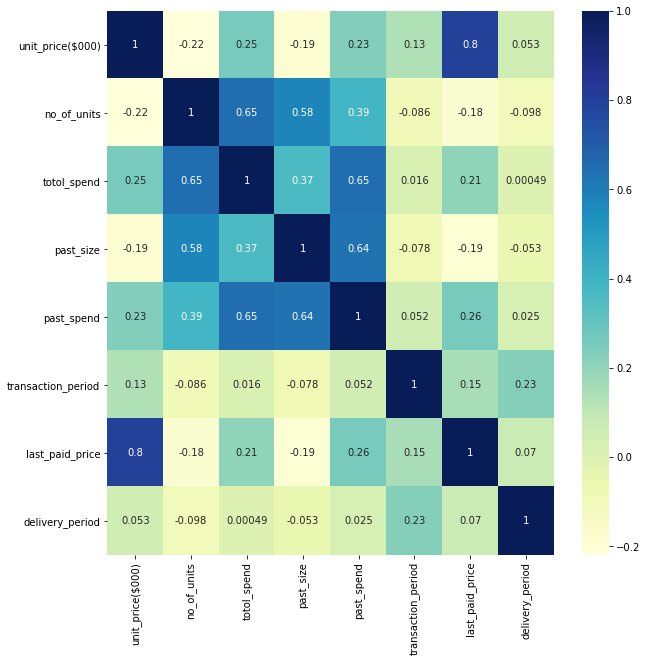

In [230]:
# Correlations using heatmap to visualize
plt.figure(figsize = (10, 10))
sns.heatmap(car_no_out[num_cols].corr(), annot = True, cmap="YlGnBu")
plt.show()

The correlations between variables show:

(1). There is a significant positive correlation between the unit price and the last paid price that is 0.8.

(2). There are postive correlations between 'unit_price$(000)' and 'last_paid_price', 'totol_spend', 'past_spend' and 'transaction_period'.

(3). Negative correlations between 'unit_price$(000)' and 'no_of_units' and 'past_size' are observed.

(4). There are postive correlations between 'past_spend' and 'totol_spend', 'past_size'.

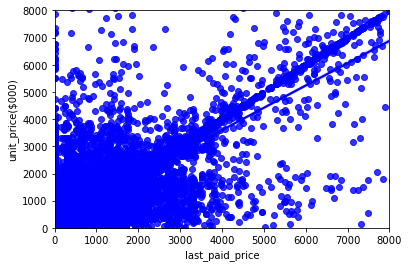

In [231]:
# Show a scatter plot of the last paid price and the unit price.
sns.regplot(x= 'last_paid_price', y='unit_price($000)' ,data= car_no_out[num_cols],color='b')
plt.xlim([0, 8000])
plt.ylim([0, 8000])
plt.show()

There is a strong indication for a linear relation, especially in the large last paid price region from the scatter plot.

## 6. Machine learning models

Because there is a significant correlation between the target 'unit_price($000)' and the 'last_paid_price' that is 0.8, it is reasonable to build a model only contains numerical features firstly then consider models with relevent categorical features.

### 6.1 Linear regression models with only numerical features

In [232]:
# Define a function to rescale the data with MinMaxScaler
def rescale(df):
    
    # df --- DataFrame, the input dataframe
    
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])

In [233]:
# Define a function to bulid ML model and present the results
def lr_func(model, df, weight_k, coef, bins, bag):
    
    # df --- DataFrame, the input dataframe
    # model --- str, specify the ML model
    # weight_k --- float, the exponential decay rate based on the transaction period
    # coef --- bool, specify if we present the coefficient for linear regression and Ridge model
    # bins --- int, specify the bins in the histogram
    # bag --- bool, specify if we apply the bagging algorithm
    
    # Train-Test spliting
    np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 10)
    # Dividing data into X and y variables
    y_train = df_train.pop('unit_price($000)')
    X_train = df_train
    y_test = df_test.pop('unit_price($000)')
    X_test = df_test
    
    # Adding a weight which decays exponentially based on the transaction period
    weight = X_train.transaction_period.array- 1
    sample_weight = np.exp(weight_k * weight)
    
    # Select BaggingRegressor if needed
    if bag == True:
        # BaggingRegressor with a base estimator
        lr = BaggingRegressor(base_estimator= model, n_estimators= 3, random_state= 10)
    else:
        lr = model
    
    # Train the model
    if weight_k == 0:
        lr.fit(X_train,y_train)
    else:
        lr.fit(X_train,y_train, sample_weight)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    # Testing set R2 Accuracy
    print('Test set Accuracy R2: {:.3f}'.format(lr.score(X_test,y_test)))
    # Training set MSE
    print('Train set RMSE: {:.3f}'.format(np.sqrt(MSE(y_train, y_train_pred))))
    # Testing set MSE
    print('Test set RMSE: {:.3f}'.format(np.sqrt(MSE(y_test, y_test_pred))))
    # Training set CV scores
    print('Training set CV scores mean: {:.3f}'.format(np.mean(cross_val_score(lr, X_train, y_train, cv = 5))))
    print('Training set CV scores: {:}'.format(cross_val_score(lr, X_train, y_train, cv = 5)))
    
    # Total revenue generated by your model vs the actual revenue
    total_revenue_pred = (y_test_pred* X_test.no_of_units).sum()
    total_revenue_actu = (y_test* X_test.no_of_units).sum()
    re_per = (total_revenue_pred - total_revenue_actu)/total_revenue_actu*100
    print('% of total revenue generated by the model vs the actual revenue: {:.2f} %'.format(re_per))
    
    # Select to present the coefficients of linear regression    
    if bag == False and coef == True:
        print(lr.coef_)
        print(lr.intercept_)
    
    # Vasualization of the prediction vs actual price
    per_test_pred_act = (y_test_pred -y_test)/y_test_pred *100
    
    # Create a figure with subplots to show the results
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    # Plot a histogram to present % of total revenue generated by the model vs the actual revenue     
    sns.distplot(per_test_pred_act,bins = bins, hist= True, color='g',norm_hist= True, kde = False)
    plt.xlim(-150, 150)
    plt.xlabel('% of the difference between the y_test_pred and the y_test')
    plt.ylabel('Probability')
    plt.title('Histogram of % of the difference for '+ str(model))

    plt.subplot(1,2,2)
    # Scatter plot to show the predicted price and the actual price for the test set 
    plt.scatter(y_test, y_test_pred)
    # Plot y = x line to compare the results     
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, color = 'pink');
    plt.xlim(-0.02, 1)
    plt.ylim(-0.15, 1)
    plt.title('y_test_pred vs y_test for '+ str(model))           
    plt.xlabel('y_test') 
    plt.ylabel('y_test_pred')
    plt.show()

In [234]:
# Rescale the numericial features and the target variable
rescale(car_num)
# Check if the data is rescaled properly before training the models
car_num.describe()

unit_price($000)   no_of_units   totol_spend     past_size  \
count      16084.000000  16084.000000  16084.000000  16084.000000   
mean           0.154661      0.128641      0.090279      0.085666   
std            0.140080      0.170864      0.129789      0.099873   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.063262      0.021415      0.015117      0.022533   
50%            0.125266      0.059513      0.039857      0.051374   
75%            0.178264      0.159988      0.109133      0.112663   
max            1.000000      1.000000      1.000000      1.000000   

         past_spend  transaction_period  last_paid_price  delivery_period  
count  16084.000000        16084.000000     16084.000000     16084.000000  
mean       0.105196            0.611287         0.185993         0.240771  
std        0.125575            0.293113         0.167770         0.202527  
min        0.000000            0.000000         0.000000         0.000000  
25%        0.027687            0.369231         0.075448         0.104460  
50%        0.061962            0.662348         0.151668         0.178404  
75%        0.135308            0.874494         0.216660         0.390845  
max        1.000000            1.000000         1.000000         1.000000

Train the linear regression model and present the results.

Test set Accuracy R2: 0.720
Train set RMSE: 0.080
Test set RMSE: 0.074
Training set CV scores mean: 0.671
Training set CV scores: [0.62374901 0.6821978  0.71300583 0.63164967 0.70575964]
% of total revenue generated by the model vs the actual revenue: 0.96 %


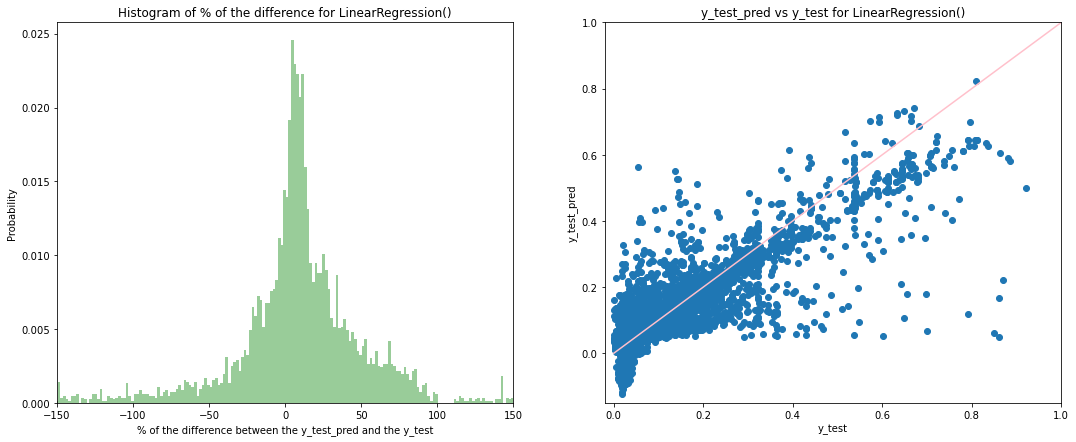

In [235]:
# Apply the machine learning model function of LinearRegression() for only the numerical features and present the results
lr_func(LinearRegression(), car_num, 0, True, 4000, True)

The linear regression model without tuning the hyperparameters shows a good accuracy(0.720) and a low root of mean squared error(0.074).

And the % of total revenue generated by the model vs the actual revenue is 0.96 %

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include categorical features in the following sections.

Train the Ridge model and present the results.

Test set Accuracy R2: 0.720
Train set RMSE: 0.080
Test set RMSE: 0.074
Training set CV scores mean: 0.671
Training set CV scores: [0.62369227 0.68215527 0.71293955 0.63150244 0.70602208]
% of total revenue generated by the model vs the actual revenue: 1.02 %


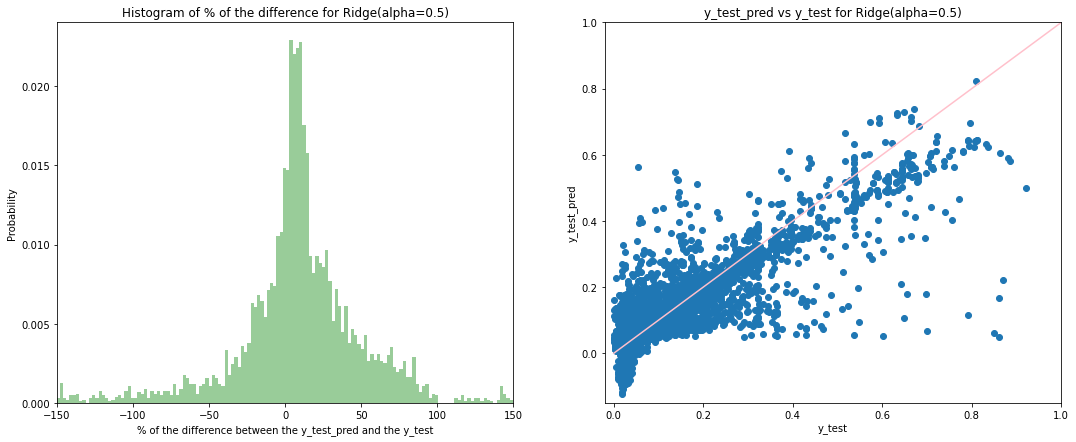

In [236]:
# Apply the machine learning model function of Ridge(alpha= 1) for only the numerical features and present the results
lr_func(Ridge(alpha= 0.5), car_num, 0, True, 4000, True)

The Ridge model( with alpha = 0.5) without tuning the hyperparameters shows a good accuracy(0.720) and a low root of mean squared error(0.074).

And the % of total revenue generated by the model vs the actual revenue is 1.02 %

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include categorical features in the following sections.

### 6.2 Linear regression models with categorical features

#### 6.2.1 Model with dummy variables for 'item_class_l2'

In [237]:
# Defining the map function to creat dummies
def dummies(x,df):
    temp = pd.get_dummies(df[x], drop_first = True, prefix= x)
    df = pd.concat([df, 1000*temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df

In [238]:
# Preparing to add dummy variables for 'item_class_l2'
num_cols_l2 = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period','item_class_l2']
car_l2 = car_no_out[num_cols_l2]

In [239]:
# Applying the function to add dummy variable for 'item_class_l2'
car_l2 = dummies('item_class_l2',car_l2)

In [240]:
# Rescaling of the input features with MinMaxScaler
rescale(car_l2)
# Check the rescaling
# car_l2.describe()

Test set Accuracy R2: 0.743
Train set RMSE: 0.076
Test set RMSE: 0.071
Training set CV scores mean: 0.702
Training set CV scores: [0.65457012 0.72053113 0.73510039 0.66803816 0.73281337]
% of total revenue generated by the model vs the actual revenue: 1.16 %


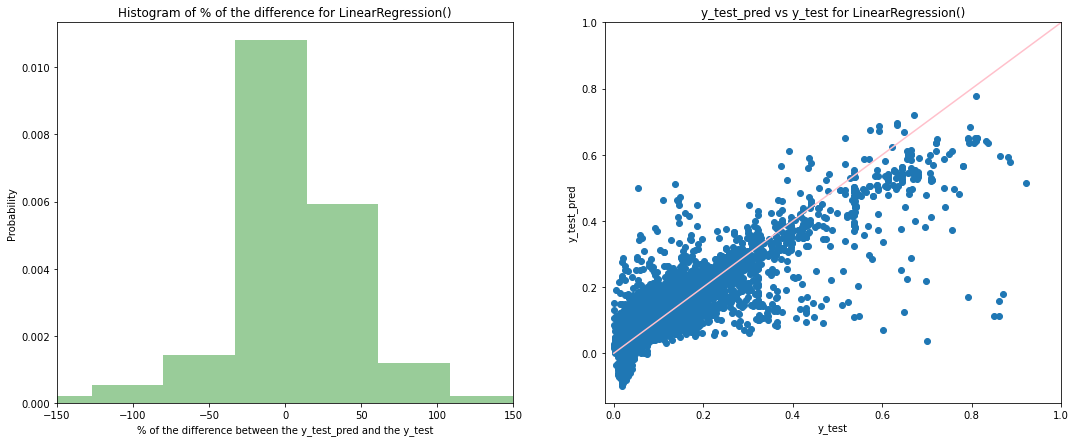

In [241]:
# Apply the machine learning model function of LinearRegression() for include 'item_class_l2' dummy variables and present the results
lr_func(LinearRegression(), car_l2, 0, False, 5000, True)

The linear regression model(weight_k = 0) without tuning the hyperparameters shows a good accuracy(0.743) and a low root of mean squared error(0.071).

And the % of total revenue generated by the model vs the actual revenue is 1.16 %

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough.

Test set Accuracy R2: 0.742
Train set RMSE: 0.076
Test set RMSE: 0.071
Training set CV scores mean: 0.703
Training set CV scores: [0.65501601 0.72126189 0.73412831 0.66859652 0.73350851]
% of total revenue generated by the model vs the actual revenue: 0.82 %


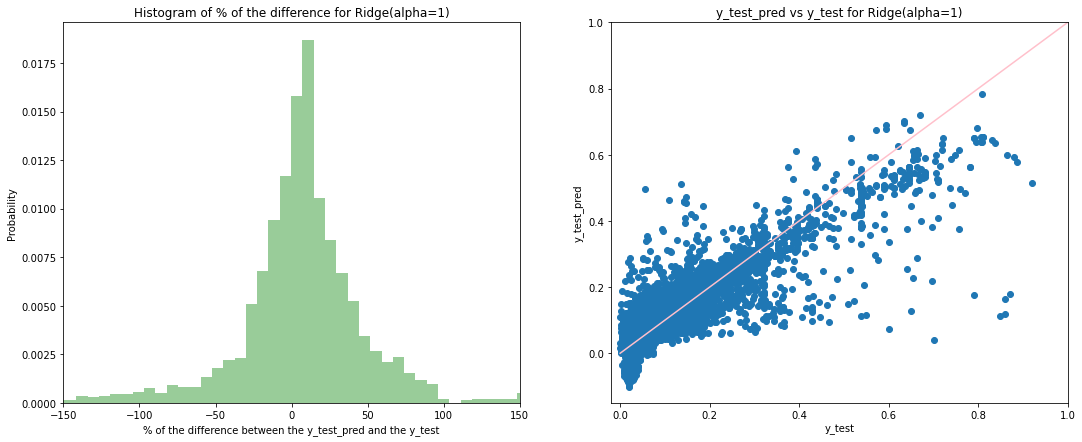

In [242]:
# Apply the machine learning model function of Ridge(alpha = 1) including 'item_class_l2' dummy variables and present the results
lr_func(Ridge(alpha = 1), car_l2, 0, False, 4000, False)

The Ridge model(alpha = 1) without tuning the hyperparameters shows a good accuracy(0.742) and a low root of mean squared error(0.071).

And the % of total revenue generated by the model vs the actual revenue is 0.82 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the prediction, there is a significant contribution(with a large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features well. We will consider to include other categorical features in the following section.

#### 6.2.2 Model with dummy variables for 'item_class_l3'

In [243]:
# Preparing to add dummy variables for 'item_class_l3'
num_cols_l3 = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period','item_class_l3']
car_l3 = car_no_out[num_cols_l3]

In [244]:
# Applying the function to add dummy variables for 'item_class_l3'
car_l3 = dummies('item_class_l3',car_l3)

In [245]:
# Rescaling of the input features with MinMaxScaler
rescale(car_l3)
# car_l3.describe()

Test set Accuracy R2: 0.749
Train set RMSE: 0.074
Test set RMSE: 0.070
Training set CV scores mean: 0.715
Training set CV scores: [0.67086311 0.73185898 0.74333047 0.68521874 0.74598216]
% of total revenue generated by the model vs the actual revenue: 0.41 %


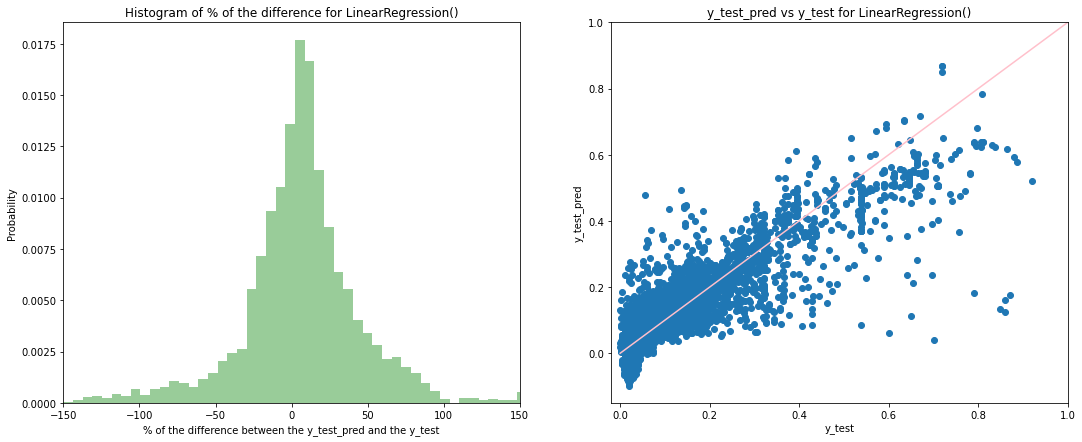

In [246]:
# Apply the machine learning model function of LinearRegression() including 'item_class_l3' dummy variables and present the results
lr_func(LinearRegression(), car_l3, 0, False, 4000, False)

The linear regression model without tuning the hyperparameters shows a good accuracy(0.749) and a low root of mean squared error(0.070).

And the % of total revenue generated by the model vs the actual revenue is 0.41 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is a significant contribution(with a large number of observations) for the errors in the small test unit price region. This shows that the current linear regression model doesn't represent the low test unit price features well.

Test set Accuracy R2: 0.750
Train set RMSE: 0.074
Test set RMSE: 0.070
Training set CV scores mean: 0.715
Training set CV scores: [0.66976197 0.73232748 0.74272384 0.68422057 0.74619842]
% of total revenue generated by the model vs the actual revenue: 0.49 %


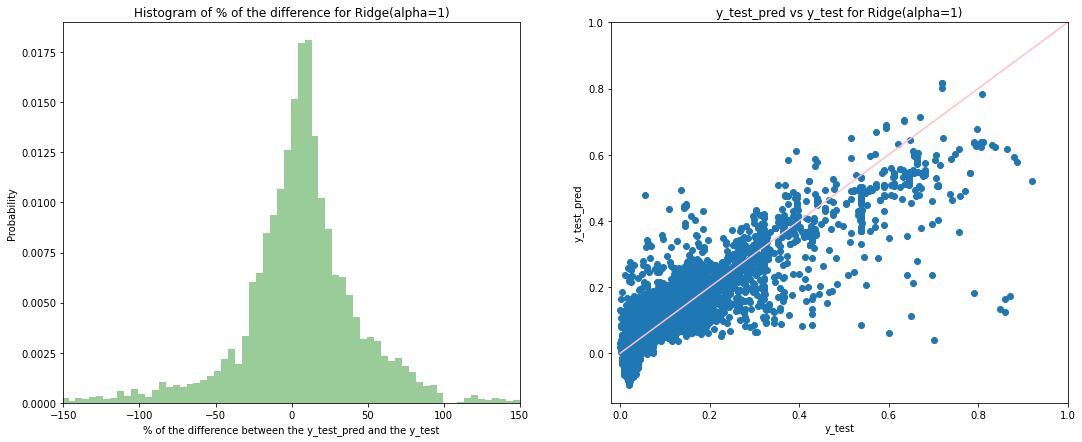

In [247]:
# Apply the machine learning model function of Ridge(alpha = 1) including 'item_class_l3' dummy variables and present the results
lr_func(Ridge(alpha = 1), car_l3, 0, False, 4000, False)

The Ridge model(alpha = 1) without tuning the hyperparameters shows a good accuracy(0.750) and a low root of mean squared error(0.070).

And the % of total revenue generated by the model vs the actual revenue is 0.49 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the prediction, there is a significant contribution(with a large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features well.

#### 6.2.3 Building model with dummy variables for 'item_class_l2' and 'item_class_l3'

In [248]:
# Preparing to add dummy variables for 'item_class_l2' and 'item_class_l3'
num_cols_both = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period','item_class_l2', 'item_class_l3']
car_both = car_no_out[num_cols_both]

In [249]:
# Applying the function
car_both = dummies('item_class_l2',car_both)
car_both = dummies('item_class_l3',car_both)

In [250]:
# Rescaling of the input features with MinMaxScaler
rescale(car_both)
# car_both.describe()

Test set Accuracy R2: -3577045838594665611264.000
Train set RMSE: 0.074
Test set RMSE: 8335986294.299
Training set CV scores mean: -1072001281273691392.000
Training set CV scores: [ 6.70534224e-01  7.31511213e-01 -5.36000641e+18  6.85609353e-01
  7.43790417e-01]
% of total revenue generated by the model vs the actual revenue: -556328269.85 %


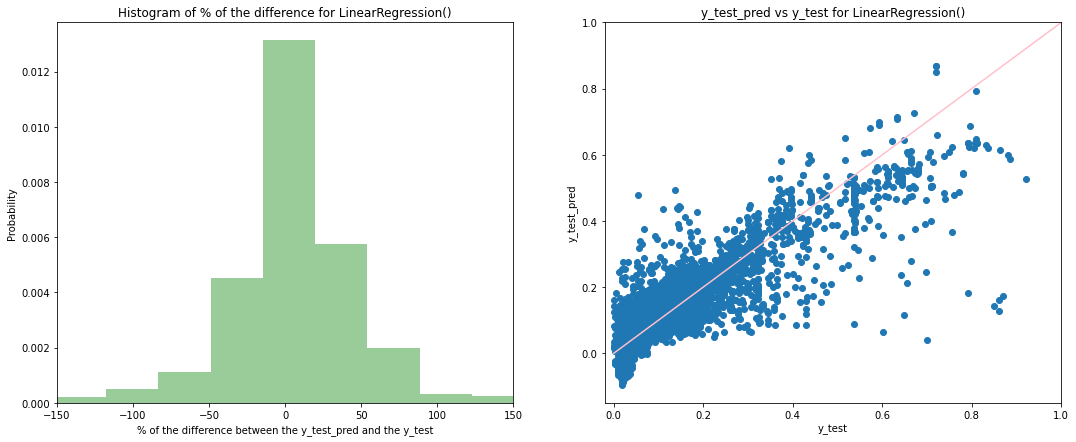

In [251]:
# The linear regression model results
lr_func(LinearRegression(), car_both, 0, False, 4000, False)

The linear regression model without tuning the hyperparameters shows an error.

Test set Accuracy R2: 0.749
Train set RMSE: 0.074
Test set RMSE: 0.070
Training set CV scores mean: 0.715
Training set CV scores: [0.67082379 0.73197076 0.74331002 0.68508152 0.74608737]
% of total revenue generated by the model vs the actual revenue: 0.41 %


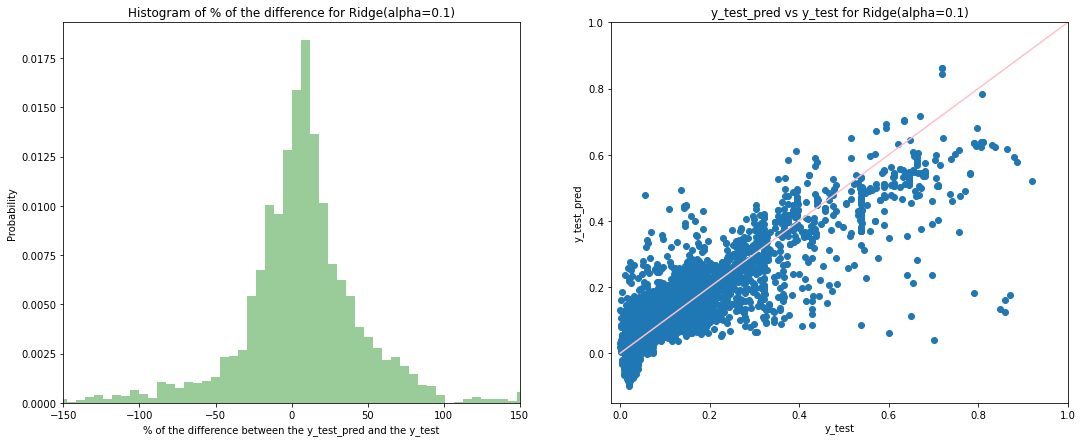

In [252]:
# The Ridge regression model results
lr_func(Ridge(alpha = 0.1), car_both, 0, False, 4000, False)

The Ridge model(alpha = 0.1) without tuning the hyperparameters shows a good accuracy(0.749) and a low root of mean squared error(0.070).

And the % of total revenue generated by the model vs the actual revenue is 0.41 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the prediction, there is a significant contribution(with a large number of observations) for the errors in the small test unit price region. This indicates that the current Ridge model doesn't represent the low test unit price features well. We will consider to include more categorical features in the following sections using Recursive Feature Elimination(RFE) method.

### 6.3 Linear regression with Recursive Feature Elimination(RFE)

#### 6.3.1 Finding main features based on the RFE

In [254]:
# Recursive feature elimination (RFE) with random forest

# Define a function to apply RFE
def RFE_func(X, y, min_fea):
    
    # X --- DataFrame, data of features
    # y --- DataFrame, target variable
    # min_fea --- int, the minimum number of features for the RFE process
    
    # Create the RFE object and rank each pixel
    clf_rf = RandomForestRegressor(n_estimators= 20, min_samples_leaf = 0.005)      
    rfe = RFE(estimator= clf_rf, n_features_to_select = min_fea, step=1)
    rfe = rfe.fit(X, y)
    print('Chosen best ' + str(min_fea) +' feature by rfe:',X.columns[rfe.support_])
#     print(rfe.ranking_)
    return X.columns[rfe.support_]

In [255]:
# Define a function to apply RFECV with cross-validation
def RFECV_func(X, y, min_fea):
    
    # X --- DataFrame, data of features
    # y --- DataFrame, target variable
    # min_fea --- int, the minimum number of features for the RFE process
    
    # Create the RFECV object and rank each pixel
    clf_rf = RandomForestRegressor(n_estimators= 20, min_samples_leaf = 0.005)      
    rfe = RFECV(estimator= clf_rf, min_features_to_select = min_fea, step=1, cv = 5)
    rfe = rfe.fit(X, y)
    print('Chosen best ' + str(min_fea) +' feature by rfe:',X.columns[rfe.support_])
#     print(rfe.ranking_)
    return X.columns[rfe.support_]

In [256]:
# Potential relevant categorical features neglecting the high cardinality categorical features, for instance 'Customer_Id' and 'car_nr', etc.
cat_dummy = ['type', 'item_class_l1', 'item_class_l2', 'item_class_l3' , 'mode_of_transport', 'most_expensive_part_l1', 'most_expensive_part_l2', 'soldto_country']

# Add dummy variables
num_cols_rfe = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period', 'type', 'item_class_l1', 'item_class_l2', 'item_class_l3', 
                'mode_of_transport', 'most_expensive_part_l1', 'most_expensive_part_l2', 'soldto_country']
# Prepare to add dummy variables 
car_rfe = car_no_out[num_cols_rfe]

In [257]:
# Applying the function to creat dummies
for x in cat_dummy:
    car_rfe = dummies(x , car_rfe)
car_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16084 entries, 0 to 16722
Columns: 140 entries, unit_price($000) to soldto_country_Zambia
dtypes: float64(8), uint16(132)
memory usage: 5.8 MB


In [258]:
# Rescaling of the input features with MinMaxScaler
rescale(car_rfe)
# Check if the data is rescaled properly
car_rfe.describe()

unit_price($000)   no_of_units   totol_spend     past_size  \
count      16084.000000  16084.000000  16084.000000  16084.000000   
mean           0.154661      0.128641      0.090279      0.085666   
std            0.140080      0.170864      0.129789      0.099873   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.063262      0.021415      0.015117      0.022533   
50%            0.125266      0.059513      0.039857      0.051374   
75%            0.178264      0.159988      0.109133      0.112663   
max            1.000000      1.000000      1.000000      1.000000   

         past_spend  transaction_period  last_paid_price  delivery_period  \
count  16084.000000        16084.000000     16084.000000     16084.000000   
mean       0.105196            0.611287         0.185993         0.240771   
std        0.125575            0.293113         0.167770         0.202527   
min        0.000000            0.000000         0.000000         0.000000   
25%        0.027687            0.369231         0.075448         0.104460   
50%        0.061962            0.662348         0.151668         0.178404   
75%        0.135308            0.874494         0.216660         0.390845   
max        1.000000            1.000000         1.000000         1.000000   

        type_manual  item_class_l1_Mid-range  ...  soldto_country_Morocco  \
count  16084.000000             16084.000000  ...            16084.000000   
mean       0.983711                 0.000062  ...                0.013989   
std        0.126590                 0.007885  ...                0.117449   
min        0.000000                 0.000000  ...                0.000000   
25%        1.000000                 0.000000  ...                0.000000   
50%        1.000000                 0.000000  ...                0.000000   
75%        1.000000                 0.000000  ...                0.000000   
max        1.000000                 1.000000  ...                1.000000   

       soldto_country_Mozambique  soldto_country_Namibia  \
count               16084.000000            16084.000000   
mean                    0.011440                0.003979   
std                     0.106347                0.062957   
min                     0.000000                0.000000   
25%                     0.000000                0.000000   
50%                     0.000000                0.000000   
75%                     0.000000                0.000000   
max                     1.000000                1.000000   

       soldto_country_Niger  soldto_country_Nigeria  soldto_country_Senegal  \
count          16084.000000            16084.000000            16084.000000   
mean               0.010818                0.026237                0.086297   
std                0.103450                0.159845                0.280811   
min                0.000000                0.000000                0.000000   
25%                0.000000                0.000000                0.000000   
50%                0.000000                0.000000                0.000000   
75%                0.000000                0.000000                0.000000   
max                1.000000                1.000000                1.000000   

       soldto_country_Somalia  soldto_country_South Africa  \
count            16084.000000                 16084.000000   
mean                 0.013554                     0.009140   
std                  0.115633                     0.095166   
min                  0.000000                     0.000000   
25%                  0.000000                     0.000000   
50%                  0.000000                     0.000000   
75%                  0.000000                     0.000000   
max                  1.000000                     1.000000   

       soldto_country_Sudan  soldto_country_Zambia  
count          16084.000000           16084.000000  
mean               0.001492               0.040662  
std                0.03860

In [259]:
# Make a copy to process the RFE
car_rfe_temp = car_rfe.copy(True)
# Dividing data into X and y variables
y = car_rfe_temp.pop('unit_price($000)')
X = car_rfe_temp

In [260]:
# Apply RFE to obtian certain number of dominated features
# The number of features are investigated and it is reasonable to set the selection below for the following process.
# col_rfe_50 = RFE_func(X, y, 50)

In [261]:
# As the RFE process is time consuming, we save the results below.
col_rfe_50 = ['no_of_units', 'totol_spend', 'past_size', 'past_spend',
       'transaction_period', 'last_paid_price', 'delivery_period',
       'type_manual', 'item_class_l1_Mid-range', 'item_class_l1_Premium',
       'item_class_l2_Aston Martin', 'item_class_l2_Bentley',
       'item_class_l2_Bugatti', 'item_class_l2_Koenigsegg',
       'item_class_l2_Lotus Cars', 'item_class_l2_McLaren Automotive',
       'item_class_l2_Pagani', 'item_class_l2_Rolls-Royce',
       'item_class_l2_W Motors', 'item_class_l3_Bentley',
       'item_class_l3_Ferrari', 'item_class_l3_Koenigsegg',
       'item_class_l3_Lamborghini1', 'item_class_l3_Lamborghini2',
       'item_class_l3_Lamborghini6', 'item_class_l3_W Motors1',
       'most_expensive_part_l1_cowl screen', 'most_expensive_part_l1_decklid',
       'most_expensive_part_l1_fascia', 'most_expensive_part_l1_fender',
       'most_expensive_part_l1_grille', 'most_expensive_part_l1_quarter panel',
       'most_expensive_part_l1_radiator', 'most_expensive_part_l1_rims',
       'most_expensive_part_l1_roof rack',
       'most_expensive_part_l1_trim package', 'most_expensive_part_l1_valance',
       'most_expensive_part_l2_bumper', 'most_expensive_part_l2_roof',
       'most_expensive_part_l2_video', 'most_expensive_part_l2_voltage',
       'most_expensive_part_l2_window seal', 'most_expensive_part_l2_windows',
       'most_expensive_part_l2_woofer', 'soldto_country_Benin',
       'soldto_country_Botswana', 'soldto_country_Burkina Faso',
       'soldto_country_Burundi', 'soldto_country_Gabon',
       'soldto_country_Kenya']

#### 6.3.2 Linear regression with the main features based on the RFE

In [262]:
# Select the 50 main features based on the RFE
col_rfe =list(col_rfe_50)
col_rfe.insert(0, 'unit_price($000)')
car_rfe_min = car_rfe[col_rfe]

Test set Accuracy R2: -283446671171.448
Train set RMSE: 0.069
Test set RMSE: 74204.530
Training set CV scores mean: -6609400612014107648.000
Training set CV scores: [ 7.27920659e-01  7.62701200e-01 -3.30469929e+19 -1.01335023e+13
  7.79805010e-01]
% of total revenue generated by the model vs the actual revenue: -126232.23 %


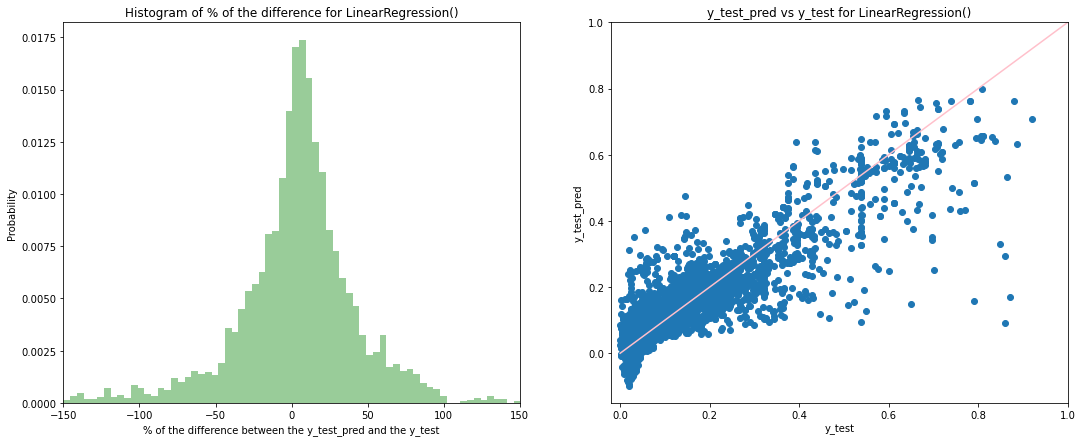

In [263]:
# The linear regression model results with the 50 main features
lr_func(LinearRegression(), car_rfe_min, 0, False, 4000, False)

The linear regression model(weight_k = 0) without tuning the hyperparameters shows an error.

#### 6.3.3 Ridge model with the main features based on the RFE

Test set Accuracy R2: 0.782
Train set RMSE: 0.069
Test set RMSE: 0.065
Training set CV scores mean: 0.756
Training set CV scores: [0.72793088 0.76269661 0.7745457  0.73536018 0.77986589]
% of total revenue generated by the model vs the actual revenue: 0.20 %


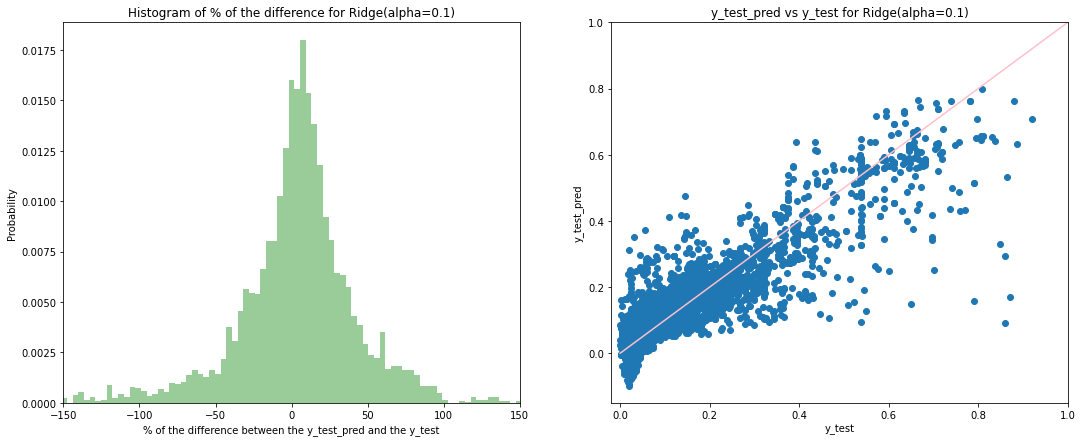

In [264]:
# The Ridge regression model results with the 50 main features
lr_func(Ridge(alpha = 0.1), car_rfe_min, 0, False, 4000, False)

The Ridge model(alpha = 0.1) without tuning the hyperparameters shows a good accuracy(0.782) and a low root of mean squared error(0.065) which is slightly better than the previoius Ridge models.

And the % of total revenue generated by the model vs the actual revenue is 0.20 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the prediction, there is a significant contribution(with a large number of observations) for the errors in the small test unit price region. This indicates that the current Ridge model doesn't represent the low test unit price features well.

#### 6.3.3 KNN regression model with the main features based on the RFE

Because the previous Ridge model shows that there is significant contribution(with a large number of observations) for the errors in the small test set unit price region, the current Ridge model shows limitations.

We apply the KNN model and decision tree regression model in the following sections.

Test set Accuracy R2: 0.878
Train set RMSE: 0.043
Test set RMSE: 0.049
Training set CV scores mean: 0.855
Training set CV scores: [0.84112299 0.86562549 0.86830972 0.82879297 0.87276119]
% of total revenue generated by the model vs the actual revenue: -0.13 %


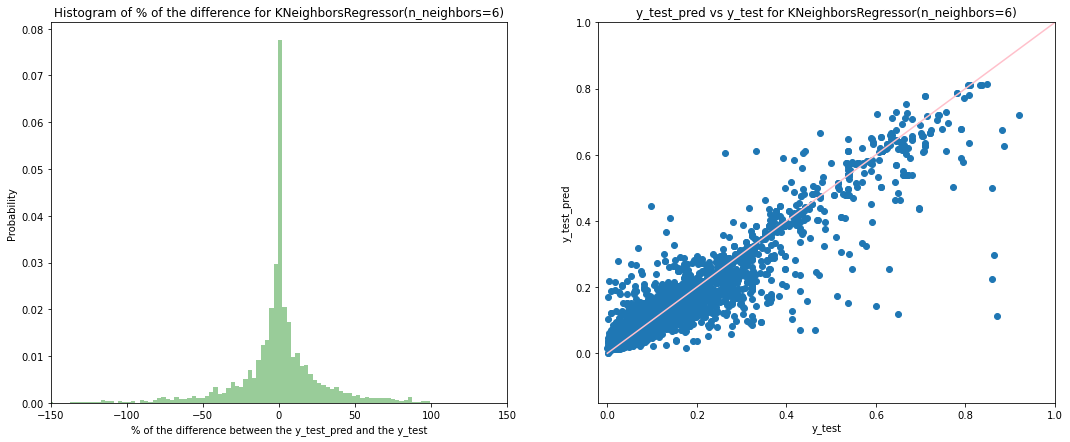

In [265]:
# The KNN Regression model results with the 50 main features
lr_func(KNeighborsRegressor(n_neighbors= 6), car_rfe_min, 0, False, 400, False)

The KNN (with n_neighbors= 6) without tuning the hyperparameters shows a very good accuracy (0.878) and a low root of mean squared error (0.049) which is better than the previoius Ridge models.

The cross-validation scores mean is 0.855 that is a high accuracy.

And the % of total revenue generated by the model vs the actual revenue is -0.13%.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-30, 30) which is smaller than the Ridge models.

From the right figure of the test unit price vs the prediction, there is no significant contribution(with a large number of observations) for the errors in the small test unit price region. This shows an improvment of the model performace compared with the Ridge model and linear regression model.

### 6.4 Decision tree regression

The decision tree regression model is applied to the data.

Test set Accuracy R2: 0.859
Train set RMSE: 0.050
Test set RMSE: 0.052
Training set CV scores mean: 0.827
Training set CV scores: [0.79764283 0.84607766 0.83676339 0.81712786 0.83877637]
% of total revenue generated by the model vs the actual revenue: 5.26 %


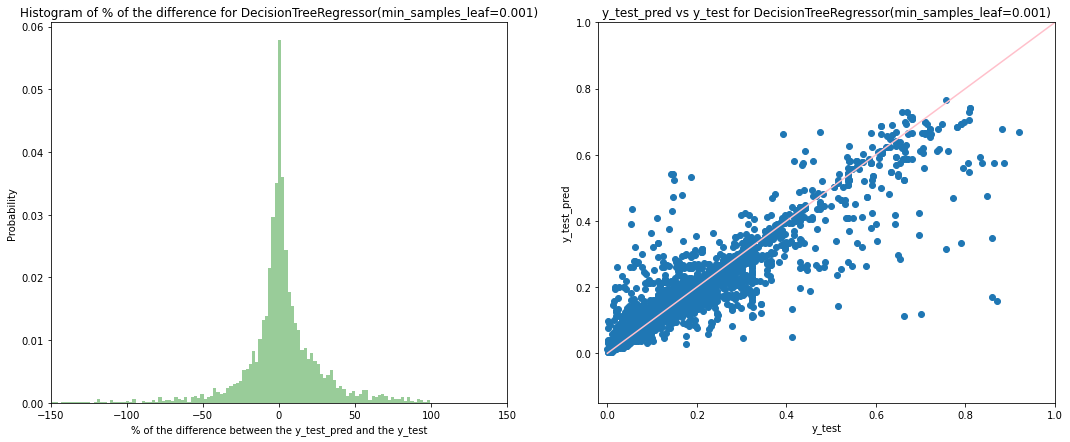

In [266]:
# The decision tree regression model results
lr_func(DecisionTreeRegressor(min_samples_leaf = 0.001), car_rfe_min, 0, False, 400, True)

The DecisionTreeRegressor (min_samples_leaf = 0.001) without tuning the hyperparameters shows a significant improvement in the accuracy (0.859) and a lower root of mean squared error (0.052) than the previous models. The cross-validation scores mean is 0.827 that is a high accuracy. These are compariable with the KNN model performance.

And the % of total revenue generated by the model vs the actual revenue is 5.26 % that is much higher than the previous Ridge models and linear regression models.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-30, 30) that is smaller than the Ridge model range (-100, 100). Besides, there is a significant amount of observations near zero that means the accuracy of these observations is very accurate.

From the right figure of the test set unit price vs the prediction, there is no significant contribution (with a large number of observations) for the errors in the small unit price region. This indicates that the performance of the decision tree regression model is better than the previous Ridge models and linear regression models.

## 7. Hyperparameters tuning

We have not process hyperparameters tuning in the previous process. By tuning hyperparameters, the accuracies of our models are expected to be improved.

We will define a function for the hyperparameters tuning process and apply hyperparameters tuning for linear regerssion model, Ridge model, KNN model and decistion tree regression model.

In [267]:
# Define a function for the following hyperparameters tuning process
def hyper_tuning(df, model, weight_k, bag):
    
    # df --- DataFrame, the input dataframe
    # model --- str, specify the ML model
    # weight_k --- float, the exponential decay rate based on the transaction period
    # bag --- bool, specify if we apply the bagging algorithm
   
    np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 10)
    # Dividing data into X and y variables
    y_train = df_train.pop('unit_price($000)')
    X_train = df_train
    y_test = df_test.pop('unit_price($000)')
    X_test = df_test
    # Adding a weight decaies expontentially based on the transaction period
    weight = X_train.transaction_period.array-1
    sample_weight = np.exp(weight_k * weight)
    if bag == True:
        # Use BaggingRegressor to reduce the variance
        lr = BaggingRegressor(base_estimator= model, n_estimators= 3, random_state= 10)
    else:
        lr = model
    if weight_k == 0:
        lr.fit(X_train,y_train)
    else:
        lr.fit(X_train,y_train, sample_weight)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    y_test_pred = lr.predict(X_test)
    # Test set Accuracy R2
    R2 = lr.score(X_test,y_test)
    return R2

### 7.1 Hyperparameter tuning for linear regression model

For the linear regression model, there is only one hyperparameter: 

'weight_k' is the exponential decay rate based on the transaction period.

In [268]:
# Define an objective function to be maximized.
def objective(trial):

    # Suggest values for the hyperparameters using a trial object.
    # 'weight_k' is the exponential decay rate based on the transaction period
    weight_k = trial.suggest_uniform('weight_k', 0, 2)
    df = car_rfe_min
    model = LinearRegression()
    bag = False
    R2 = hyper_tuning(df, model, weight_k, bag)
    return R2

In [269]:
# Create a study object and optimize the objective function.
# Run the tuning for certain number of trials and present the best parameters.
study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-22 19:26:43,847] A new study created in memory with name: no-name-587f4da7-e6fa-4a88-a287-0086c41b0ca5
[I 2021-10-22 19:26:43,876] Trial 0 finished with value: -82247421363391.11 and parameters: {'weight_k': 1.0655822015280336}. Best is trial 0 with value: -82247421363391.11.
[I 2021-10-22 19:26:43,903] Trial 1 finished with value: -3648697535641.8696 and parameters: {'weight_k': 1.0109984401855445}. Best is trial 1 with value: -3648697535641.8696.
[I 2021-10-22 19:26:43,931] Trial 2 finished with value: -10665892478513.082 and parameters: {'weight_k': 0.6146645061934015}. Best is trial 1 with value: -3648697535641.8696.
[I 2021-10-22 19:26:43,959] Trial 3 finished with value: -996556390645.3258 and parameters: {'weight_k': 1.2015256161993342}. Best is trial 3 with value: -996556390645.3258.
[I 2021-10-22 19:26:43,987] Trial 4 finished with value: -290092697661363.2 and parameters: {'weight_k': 0.7746522675764556}. Best is trial 3 with value: -996556390645.3258.
[I 2021-10-2

[I 2021-10-22 19:26:45,164] Trial 43 finished with value: -2889097360550145.0 and parameters: {'weight_k': 0.5951842273784519}. Best is trial 37 with value: 0.7821144229026268.
[I 2021-10-22 19:26:45,193] Trial 44 finished with value: -36410679216074.01 and parameters: {'weight_k': 0.9736660744814495}. Best is trial 37 with value: 0.7821144229026268.
[I 2021-10-22 19:26:45,223] Trial 45 finished with value: -4.2442273349320625e+20 and parameters: {'weight_k': 0.24756674528627337}. Best is trial 37 with value: 0.7821144229026268.
[I 2021-10-22 19:26:45,251] Trial 46 finished with value: -1585852974920.2375 and parameters: {'weight_k': 0.1475195768643186}. Best is trial 37 with value: 0.7821144229026268.
[I 2021-10-22 19:26:45,281] Trial 47 finished with value: -18000059755594.68 and parameters: {'weight_k': 0.41453182236214586}. Best is trial 37 with value: 0.7821144229026268.
[I 2021-10-22 19:26:45,311] Trial 48 finished with value: -14354386179662.582 and parameters: {'weight_k': 0.73

[I 2021-10-22 19:26:46,488] Trial 87 finished with value: -62715132243784.62 and parameters: {'weight_k': 0.559177462386427}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:46,519] Trial 88 finished with value: -468890990564633.2 and parameters: {'weight_k': 0.34142035647084856}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:46,549] Trial 89 finished with value: -82808373434.81052 and parameters: {'weight_k': 0.6315352132018985}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:46,579] Trial 90 finished with value: -5842612866170.22 and parameters: {'weight_k': 0.4894244550922623}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:46,610] Trial 91 finished with value: -46491017220367.56 and parameters: {'weight_k': 0.05349648438403448}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:46,640] Trial 92 finished with value: -197911130726915.75 and parameters: {'weight_k': 0.13192665606

[I 2021-10-22 19:26:47,839] Trial 131 finished with value: -1124440962828567.4 and parameters: {'weight_k': 0.8463095213174906}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:47,869] Trial 132 finished with value: -23720207596409.598 and parameters: {'weight_k': 0.9917320163885462}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:47,900] Trial 133 finished with value: -125827511356939.64 and parameters: {'weight_k': 0.8242158927797136}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:47,931] Trial 134 finished with value: -1136670442625097.2 and parameters: {'weight_k': 0.3864445968928548}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:47,972] Trial 135 finished with value: -60619327447375.54 and parameters: {'weight_k': 0.9175007054121139}. Best is trial 83 with value: 0.7821151764731842.
[I 2021-10-22 19:26:48,001] Trial 136 finished with value: -229569737148610.66 and parameters: {'weight_k': 0.5

Number of finished trials: 150
Best trial: {'weight_k': 0.41606296040964497}


Without regularization, the linear regression model shows some error.

In [270]:
# Plot_optimization_historY: shows the scores from all trials as well as the best score so far at each point.
# optuna.visualization.plot_optimization_history(study)

In [271]:
# Plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
# optuna.visualization.plot_parallel_coordinate(study)

In [272]:
# '''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
# went and which parts of the space were explored more.'''
# optuna.visualization.plot_slice(study)

In [273]:
# Visualize empirical distribution function
# optuna.visualization.plot_edf(study)

{'weight_k': 0.41606296040964497}
Test set Accuracy R2: 0.782
Train set RMSE: 0.069
Test set RMSE: 0.065
Training set CV scores mean: -6609400612014107648.000
Training set CV scores: [ 7.27920659e-01  7.62701200e-01 -3.30469929e+19 -1.01335023e+13
  7.79805010e-01]
% of total revenue generated by the model vs the actual revenue: -0.33 %


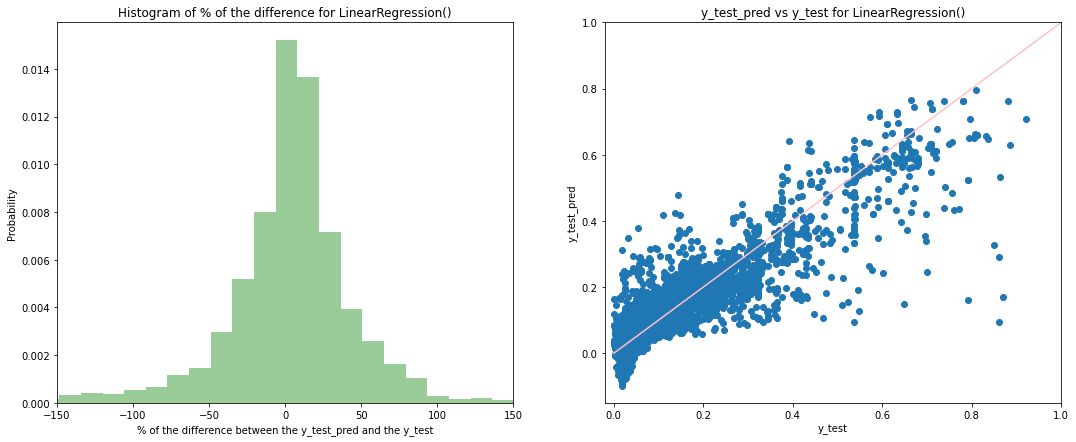

In [274]:
print(study.best_params)
weight_k_opt = 0.3842722724922907
lr_func(LinearRegression(), car_rfe_min, weight_k_opt, False, 5000, False)

Without regularization, we observe an error shown by the linear regression model in the hyperparameter tuning process.

### 7.2 Hyperparameter tuning for Ridge model

For the Ridge model, there are two hyperparameters: 

1). 'weight_k' is the exponential decay rate based on the transaction period.

2). 'alpha' is the parameter for the regularization.

In [275]:
# Define an objective function to be maximized
def objective(trial):
    # Suggest values for the hyperparameters using a trial object
    # 'weight_k' is the exponential decay rate based on the transaction period
    # 'alpha' is the parameter for the regularization
    weight_k = trial.suggest_uniform('weight_k', 0, 5)
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e1)
    # Seting the bagging option
    bag = False
    df = car_rfe_min
    model = Ridge(alpha= alpha)
    
    R2 = hyper_tuning(df, model, weight_k, bag)
    return R2

In [276]:
# Create a study object and optimize the objective function
# Run the tuning for certain number of trials and present the best parameters
study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-22 19:26:53,596] A new study created in memory with name: no-name-eadee2d2-757b-402c-92f2-7047ca55ef07
[I 2021-10-22 19:26:53,617] Trial 0 finished with value: 0.7779164147784894 and parameters: {'weight_k': 3.873196849450984, 'alpha': 0.008436646670498628}. Best is trial 0 with value: 0.7779164147784894.
[I 2021-10-22 19:26:53,638] Trial 1 finished with value: 0.7792526657722171 and parameters: {'weight_k': 1.6776243839144338, 'alpha': 4.23723165829976}. Best is trial 1 with value: 0.7792526657722171.
[I 2021-10-22 19:26:53,659] Trial 2 finished with value: 0.7815490022496545 and parameters: {'weight_k': 0.04435701623868693, 'alpha': 2.034683407029838}. Best is trial 2 with value: 0.7815490022496545.
[I 2021-10-22 19:26:53,680] Trial 3 finished with value: 0.777335921195481 and parameters: {'weight_k': 4.201961293461101, 'alpha': 0.1771704900022868}. Best is trial 2 with value: 0.7815490022496545.
[I 2021-10-22 19:26:53,701] Trial 4 finished with value: 0.7765385730382717 a

[I 2021-10-22 19:26:54,799] Trial 37 finished with value: 0.7820415775736905 and parameters: {'weight_k': 0.3975422389403892, 'alpha': 0.28805327204172676}. Best is trial 31 with value: 0.782114679299706.
[I 2021-10-22 19:26:54,824] Trial 38 finished with value: 0.7820384179112168 and parameters: {'weight_k': 0.07647990786857578, 'alpha': 0.0019698933085693605}. Best is trial 31 with value: 0.782114679299706.
[I 2021-10-22 19:26:54,849] Trial 39 finished with value: 0.7818871992703851 and parameters: {'weight_k': 0.7892878263239607, 'alpha': 0.4364191032988663}. Best is trial 31 with value: 0.782114679299706.
[I 2021-10-22 19:26:54,874] Trial 40 finished with value: 0.7811548813389257 and parameters: {'weight_k': 1.7005466730191958, 'alpha': 0.05675919949946224}. Best is trial 31 with value: 0.782114679299706.
[I 2021-10-22 19:26:54,898] Trial 41 finished with value: 0.7821137951741088 and parameters: {'weight_k': 0.36402843504305804, 'alpha': 0.0018180285432915278}. Best is trial 31 w

[I 2021-10-22 19:26:55,757] Trial 75 finished with value: 0.7819956455509967 and parameters: {'weight_k': 0.0018189975156377436, 'alpha': 0.015119346297772555}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:55,782] Trial 76 finished with value: 0.7820883068313358 and parameters: {'weight_k': 0.6016850758018208, 'alpha': 0.001490619034302271}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:55,806] Trial 77 finished with value: 0.781910205984221 and parameters: {'weight_k': 0.970985583285316, 'alpha': 0.0004731045754014318}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:55,830] Trial 78 finished with value: 0.7820183839382628 and parameters: {'weight_k': 0.7608938365204627, 'alpha': 0.04315280646627788}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:55,855] Trial 79 finished with value: 0.7821149662563617 and parameters: {'weight_k': 0.4228866303326204, 'alpha': 0.00020531832282405502}. Best is tri

[I 2021-10-22 19:26:56,725] Trial 113 finished with value: 0.7817449765900584 and parameters: {'weight_k': 0.2168730293737498, 'alpha': 1.410603914970867}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:56,751] Trial 114 finished with value: 0.7820001175170104 and parameters: {'weight_k': 0.003844884564730089, 'alpha': 0.00012356965513119858}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:56,776] Trial 115 finished with value: 0.7820052968326024 and parameters: {'weight_k': 0.8119562370021166, 'alpha': 0.0033292740768397556}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:56,801] Trial 116 finished with value: 0.7763579411618897 and parameters: {'weight_k': 4.987912757974074, 'alpha': 0.002108027288312123}. Best is trial 59 with value: 0.7821150077701837.
[I 2021-10-22 19:26:56,826] Trial 117 finished with value: 0.7821110709540222 and parameters: {'weight_k': 0.47942262572228833, 'alpha': 0.0008015489694877274}. Best i

Number of finished trials: 150
Best trial: {'weight_k': 0.42312723696780724, 'alpha': 1.9980532718321524e-05}


In [277]:
# Plot_optimization_historY: shows the scores from all trials as well as the best score so far at each point
optuna.visualization.plot_optimization_history(study)

In [278]:
# Plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [279]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [280]:
# Plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['alpha', 'weight_k'])

In [281]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

The importance of hyperparameters: the importance of 'weight_k' is much higher than the importance of 'alpha'.

In [282]:
# Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [283]:
# Show the best parameters
print(study.best_params)

{'weight_k': 0.42312723696780724, 'alpha': 1.9980532718321524e-05}


{'weight_k': 0.42312723696780724, 'alpha': 1.9980532718321524e-05}
Test set Accuracy R2: 0.782
Train set RMSE: 0.069
Test set RMSE: 0.065
Training set CV scores mean: 0.756
Training set CV scores: [0.72791703 0.76266537 0.77455146 0.73537202 0.77983988]
% of total revenue generated by the model vs the actual revenue: -0.15 %


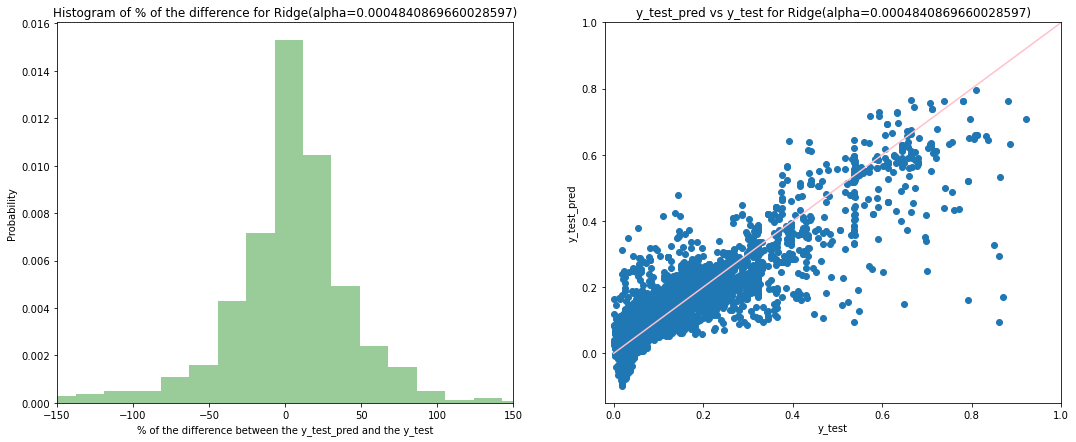

In [284]:
# Apply the best hyperparameters to the Ridge model and presents the results.
print(study.best_params)
alpha_opt = 0.0004840869660028597
weight_k_opt = 0.25287747923377046
lr_func(Ridge(alpha = alpha_opt), car_rfe_min, weight_k_opt, False, 15000, False)

The Ridge model with the tuned hyperparameters shows a slight improvement in the accuracy(0.782) and a root of mean squared error(0.065) than the previous Ridge model. The mean of training set cross-validation scores is 0.756.

And the % of total revenue generated by the model vs the actual revenue is -0.15 % that is slightly lower than the previous Ridge model with 0.20%.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-70, 70) that is smaller than the Ridge model range (-100, 100).

From the right figure of the test set unit price vs the prediction, there is a significant contribution(with a large number of observations) for the errors in the small unit price region.

### 7.3 Hyperparameter tuning for the KNN regression model using Optuna

We tune the hyperparameters of 'n_neighbors' for the KNeighborsRegressor.

In [285]:
# Define an objective function to be maximized.
def objective(trial):

    # Suggest values for the hyperparameters using a trial object.
    # 'knn' is the parameter 'n_neighbors' for the KNN regression
    knn = trial.suggest_int('knn', 2, 10)
    # 'weight_k' is the exponential decay rate based on the transaction period
    weight_k = 0
    # Seting the bagging option
    bag = False
    df = car_rfe_min
    model = KNeighborsRegressor(n_neighbors= knn)
    
    R2 = hyper_tuning(df, model, weight_k, bag)
    return R2

In [286]:
# Create a study object and optimize the objective function.
study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-22 19:27:15,045] A new study created in memory with name: no-name-208bde88-e4be-4b8f-8a41-d4cd3fdd617d
[I 2021-10-22 19:27:19,150] Trial 0 finished with value: 0.8653772699710978 and parameters: {'knn': 9}. Best is trial 0 with value: 0.8653772699710978.
[I 2021-10-22 19:27:23,169] Trial 1 finished with value: 0.8678673957342526 and parameters: {'knn': 8}. Best is trial 1 with value: 0.8678673957342526.
[I 2021-10-22 19:27:27,180] Trial 2 finished with value: 0.8653772699710978 and parameters: {'knn': 9}. Best is trial 1 with value: 0.8678673957342526.
[I 2021-10-22 19:27:30,280] Trial 3 finished with value: 0.8797149647818294 and parameters: {'knn': 3}. Best is trial 3 with value: 0.8797149647818294.
[I 2021-10-22 19:27:33,375] Trial 4 finished with value: 0.8797149647818294 and parameters: {'knn': 3}. Best is trial 3 with value: 0.8797149647818294.
[I 2021-10-22 19:27:37,350] Trial 5 finished with value: 0.8729358099927691 and parameters: {'knn': 7}. Best is trial 3 with v

Number of finished trials: 30
Best trial: {'knn': 4}


In [287]:
# Best trial: {'knn': 4}

In [288]:
# Plot_optimization_historY: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [289]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [290]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [291]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
# optuna.visualization.plot_contour(study, params=['knn'])

In [292]:
#Visualize parameter importances.
# optuna.visualization.plot_param_importances(study)

The importance of 'leaf' is dominated compared with the importance of 'weight_k'.

In [293]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [294]:
# Present the best parameters
print(study.best_params)

{'knn': 4}


{'knn': 4}
Test set Accuracy R2: 0.876
Train set RMSE: 0.040
Test set RMSE: 0.049
Training set CV scores mean: 0.857
Training set CV scores: [0.84129229 0.86839327 0.87352106 0.82692127 0.87668764]
% of total revenue generated by the model vs the actual revenue: -0.37 %


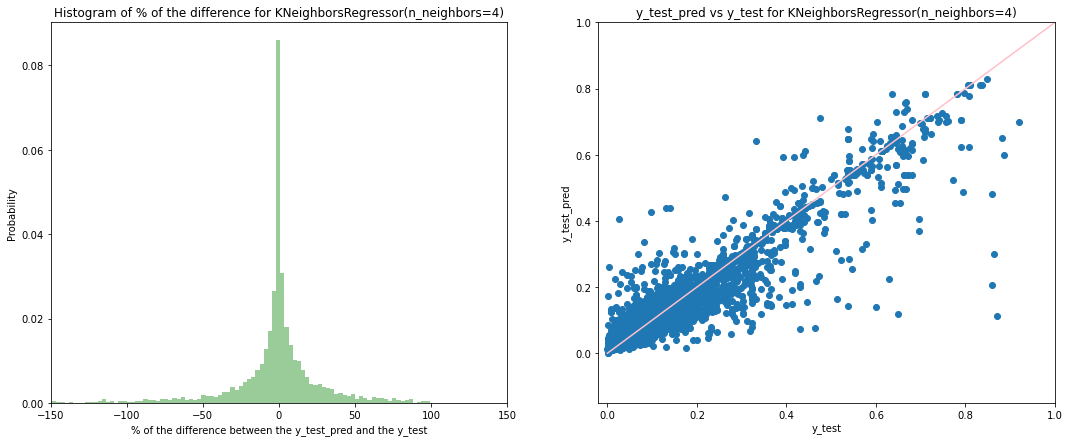

In [295]:
# Apply the tuned parameters to show the results
knn_opt = 4
print(study.best_params)
lr_func(KNeighborsRegressor(n_neighbors= knn_opt), car_rfe_min, 0, False , 400, True)

The KNeighborsRegressor with tuned hyperparameters (n_neighbors= 4) shows an significant improvement in the accuracy (0.876) and a lower root of mean squared error (0.049) than the previous Ridge models and linear regression models. The cross-validation shows a mean of R2 scores of 0.857 that is very good.

And the % of total revenue generated by the model vs the actual revenue is -0.37 % that is slightly lower than the previous Ridge model.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-30, 30) that is smaller than the Ridge model (-70, 70). Besides, there is a significant amount of observations near zero that means the accuracy of these observations is very good.

From the right figure of the test unit price vs the predition, there is no significant contribution (with a large number of observations) for the errors in the small unit price region. This indicates that the performance of the KNN model is better than the previous Ridge models and linear regression models.

### 7.4 Hyperparameter tuning for the decision tree regression model

#### 7.4.1 Hyperparameter tuning using RandomizedSearchCV

In [296]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Setup the hyperparameter grid
# 'leaf_space' is the parameter 'min_samples_leaf' for DecisionTreeRegressor()
leaf_space = np.arange(0.0001, 0.01, 0.00001)
param_grid = {'min_samples_leaf': leaf_space}

# Instantiate a decision tree regression model
dtr = DecisionTreeRegressor()

# Instantiate the GridSearchCV object:
df = car_rfe_min
model = RandomizedSearchCV(dtr, param_grid, cv= 5)
weight_k = 0

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 10)
# Dividing data into X and y variables
y_train = df_train.pop('unit_price($000)')
X_train = df_train
y_test = df_test.pop('unit_price($000)')
X_test = df_test
# Adding a weight decaies expontentially based on the transaction period
weight = X_train.transaction_period.array-1
sample_weight = np.exp(weight_k * weight)
# regression model
lr = model
lr.fit(X_train,y_train, sample_weight)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_test_pred = lr.predict(X_test)

print('Test set Accuracy R2: {:.3f}'.format(lr.score(X_test,y_test)))
# Training set MSE
print('Train set RMSE: {:.3f}'.format(np.sqrt(MSE(y_train, y_train_pred))))
# Test set MSE
print('Test set RMSE: {:.3f}'.format(np.sqrt(MSE(y_test, y_test_pred))))

# Print the tuned parameter and score
print("Tuned Decision Tree Regression Parameters: min_samples_leaf: {:.5f}".format(lr.best_params_['min_samples_leaf']))
print("Best score is {:.3f}".format(lr.best_score_))

Test set Accuracy R2: 0.842
Train set RMSE: 0.038
Test set RMSE: 0.055
Tuned Decision Tree Regression Parameters: min_samples_leaf: 0.00041
Best score is 0.821


For the decision tree regression model, the hyperparameter tuning using RandomizedSearchCV gives a R2 accuracy score of 0.821 with min_samples_leaf: 0.00041.

#### 7.4.2 Hyperparameters tuning using Optuna

We tune the hyperparameters of 'min_samples_leaf' and 'weight_k'.

In [297]:
# Define an objective function to be maximized.
def objective(trial):

    # Suggest values for the hyperparameters using a trial object.
    # 'leaf' is the parameter 'min_samples_leaf' for DecisionTreeRegressor()
    # 'weight_k' is the exponential decay rate based on the transaction period
    leaf = trial.suggest_loguniform('leaf', 2e-4, 1e-1)
    weight_k = trial.suggest_uniform('weight_k', 0, 5)
    # Setting the bagging option
    bag = True
    df = car_rfe_min
    model = DecisionTreeRegressor(min_samples_leaf = leaf)
    R2 = hyper_tuning(df, model, weight_k, bag)
    return R2

In [298]:
# Create a study object and optimize the objective function.
study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-22 19:29:27,402] A new study created in memory with name: no-name-7c556263-4cb2-4703-8bf1-61186dbee214
[I 2021-10-22 19:29:27,486] Trial 0 finished with value: 0.6904370067042057 and parameters: {'leaf': 0.04172182019569046, 'weight_k': 2.1764785326778324}. Best is trial 0 with value: 0.6904370067042057.
[I 2021-10-22 19:29:27,649] Trial 1 finished with value: 0.8470040475513647 and parameters: {'leaf': 0.0007926170407243982, 'weight_k': 2.4625948271654368}. Best is trial 1 with value: 0.8470040475513647.
[I 2021-10-22 19:29:27,747] Trial 2 finished with value: 0.7455875521510256 and parameters: {'leaf': 0.0214786264089489, 'weight_k': 4.742289986861851}. Best is trial 1 with value: 0.8470040475513647.
[I 2021-10-22 19:29:27,915] Trial 3 finished with value: 0.838569568751531 and parameters: {'leaf': 0.0005443204201457441, 'weight_k': 4.463945212463068}. Best is trial 1 with value: 0.8470040475513647.
[I 2021-10-22 19:29:28,050] Trial 4 finished with value: 0.797775529072522

[I 2021-10-22 19:29:33,230] Trial 37 finished with value: 0.8857779533172143 and parameters: {'leaf': 0.00029113555071482876, 'weight_k': 1.3966696938586187}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:33,396] Trial 38 finished with value: 0.8687747854065796 and parameters: {'leaf': 0.0005518446058152623, 'weight_k': 1.8513679668754144}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:33,522] Trial 39 finished with value: 0.7918915348470958 and parameters: {'leaf': 0.004660770284562437, 'weight_k': 2.246117729714833}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:33,713] Trial 40 finished with value: 0.866863675020118 and parameters: {'leaf': 0.0003031076183112756, 'weight_k': 3.457766329584065}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:33,901] Trial 41 finished with value: 0.8842138670672894 and parameters: {'leaf': 0.00025849744836461665, 'weight_k': 1.4578622342594372}. Best is trial 24

[I 2021-10-22 19:29:39,822] Trial 75 finished with value: 0.8803386402335047 and parameters: {'leaf': 0.00047562532042213037, 'weight_k': 1.1641063185474336}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:39,990] Trial 76 finished with value: 0.8812421936410794 and parameters: {'leaf': 0.000382961068941956, 'weight_k': 0.9231817425230832}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:40,170] Trial 77 finished with value: 0.8841794920355001 and parameters: {'leaf': 0.00030807823460307643, 'weight_k': 1.4611730339247206}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:40,348] Trial 78 finished with value: 0.8880948529118733 and parameters: {'leaf': 0.00023230515769194618, 'weight_k': 0.5602125532180089}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:40,525] Trial 79 finished with value: 0.8895186425607413 and parameters: {'leaf': 0.0002827537625012663, 'weight_k': 0.8403711483061318}. Best is tria

[I 2021-10-22 19:29:46,444] Trial 113 finished with value: 0.8855258111944323 and parameters: {'leaf': 0.00025564442588858646, 'weight_k': 1.4465219711740327}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:46,617] Trial 114 finished with value: 0.8853507292940446 and parameters: {'leaf': 0.0003088808342836379, 'weight_k': 0.507127140455518}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:46,804] Trial 115 finished with value: 0.8867205024070934 and parameters: {'leaf': 0.00020061229548437647, 'weight_k': 1.670771819588007}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:46,993] Trial 116 finished with value: 0.8907340086180623 and parameters: {'leaf': 0.00026479976620599435, 'weight_k': 1.0963108744040715}. Best is trial 24 with value: 0.8938913879103615.
[I 2021-10-22 19:29:47,087] Trial 117 finished with value: 0.7091596789524893 and parameters: {'leaf': 0.023108611504065953, 'weight_k': 0.719538250390364}. Best is tr

Number of finished trials: 150
Best trial: {'leaf': 0.00023159524786062256, 'weight_k': 0.8714511804058563}


In [299]:
# Best trial: {'leaf': 0.00023159524786062256, 'weight_k': 0.8714511804058563}

In [300]:
# Plot_optimization_historY: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [301]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [302]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [303]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['leaf', 'weight_k'])

In [304]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

The importance of 'leaf' is dominated compared with the importance of 'weight_k'.

In [305]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [306]:
# Present the best parameters
print(study.best_params)

{'leaf': 0.00023159524786062256, 'weight_k': 0.8714511804058563}


{'leaf': 0.00023159524786062256, 'weight_k': 0.8714511804058563}
Test set Accuracy R2: 0.894
Train set RMSE: 0.036
Test set RMSE: 0.045
Training set CV scores mean: 0.854
Training set CV scores: [0.80977578 0.87667255 0.85999451 0.85948861 0.86357538]
% of total revenue generated by the model vs the actual revenue: 3.60 %


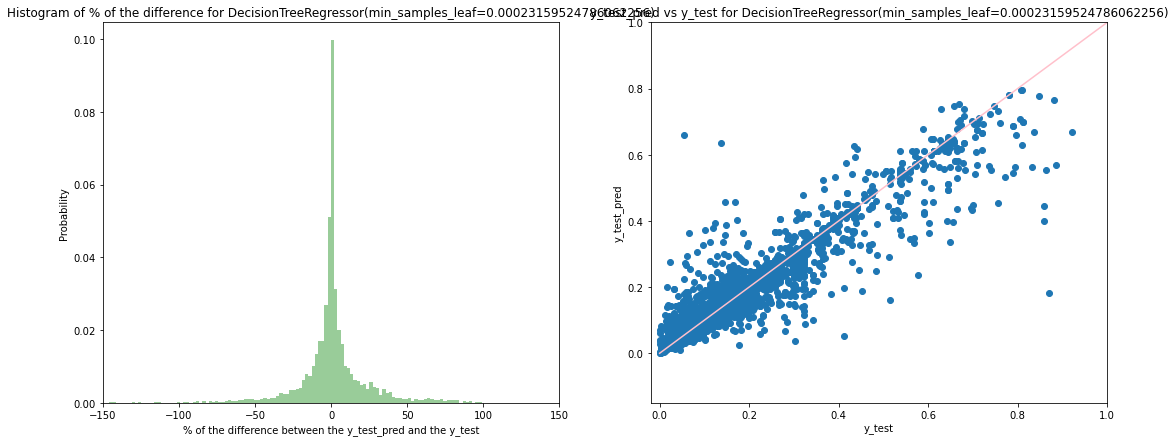

In [307]:
# Apply the tuned parameters to show the results
leaf_opt = 0.00023159524786062256
weight_k_opt = 0.8714511804058563
print(study.best_params)
lr_func(DecisionTreeRegressor(min_samples_leaf = leaf_opt), car_rfe_min, weight_k_opt, False , 400, True)

The DecisionTreeRegressor with tuned hyperparameters shows a significant improvement in the accuracy (0.894) and a lower root of mean squared error (0.045) compared with the previous Ridge models and linear regression models.

The cross-validation shows a mean of R2 scores of 0.854 that is very good.

And the % of total revenue generated by the model vs the actual revenue is 3.60 % that is much higher than the previous Ridge models, linear regression models and the KNN model.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-30, 30) that is smaller than the Ridge model (-100, 100). Besides, there is a significant amount of observations near zero that means the accuracy of these observations is very accurate.

From the right figure of the test unit price vs the predition, there is no significant contribution (with a large number of observations) for the errors in the small unit price region. This indicates that the performance of the decision tree regression model is better than the previous Ridge models and linear regression models.

## 8. Conclusions

We have explored the linear regression models, Ridge models, KNN model and decision tree regression model for the project.

The EDA, visualization and correlation analysis indicate the features' importances.

The RFE is useful to select the dominated features automatically.

The hyperparameters tuning process is important to find the optimal hyperparameters.

The comparison of the results shows that the decision tree regression model presents the best R2 accuracy score of 0.894 (with the mean cross-validation score of 0.854) and the root of mean squared error 0.045 (with the train set RMSE of 0.036). And the % of total revenue generated by the model vs the actual revenue is 3.60 %.

The results for the KNN model are comparable to the decision tree regression model. It shows a R2 accuracy score of 0.876 (with the mean cross-validation score of 0.857) and the root of the mean squared error 0.049(with the train set RMSE of 0.040). And the % of total revenue generated by the model vs the actual revenue is -0.37 %.

The Ridge model shows the second-best performance with the R2 accuracy score of 0.782 (with the mean cross-validation score of 0.756) and the root of mean squared error of 0.065 (with the train set RMSE of 0.069). And the % of total revenue generated by the model vs the actual revenue is -0.15%.

To sum up, because the target variable unit price is strongly correlated with a few features (especially the correlation with the last paid price that is 0.8) in the dataset, the 'discrete' like features are dominated in the problem. Therefore, the Decision tree model and KNN model perform better than the continuous linear models (linear regression model and Ridge model).

Note that re-tuning the hyperparameters using Optuna would lead to small changes in the tuned hyperparameters. However, the mean of training set cross-validation scores (0.854 for the decision tree regression model) indicates that there is only small variations in the accuracy of the model.